# Import the Required Libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Required for progressbar widget
import progressbar
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
print("TensorFlow v" + tf.__version__)
print("Numpy v" + np.__version__)

TensorFlow v2.11.0
Numpy v1.23.5


# Load the Dataset

In [4]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)

(5363863, 3)


In [5]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [6]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
print(train_protein_ids.shape)

(142246,)


In [7]:
train_protein_ids[:5]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366'], dtype='<U10')

In [8]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


In [9]:
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


# Prepare the dataset

Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

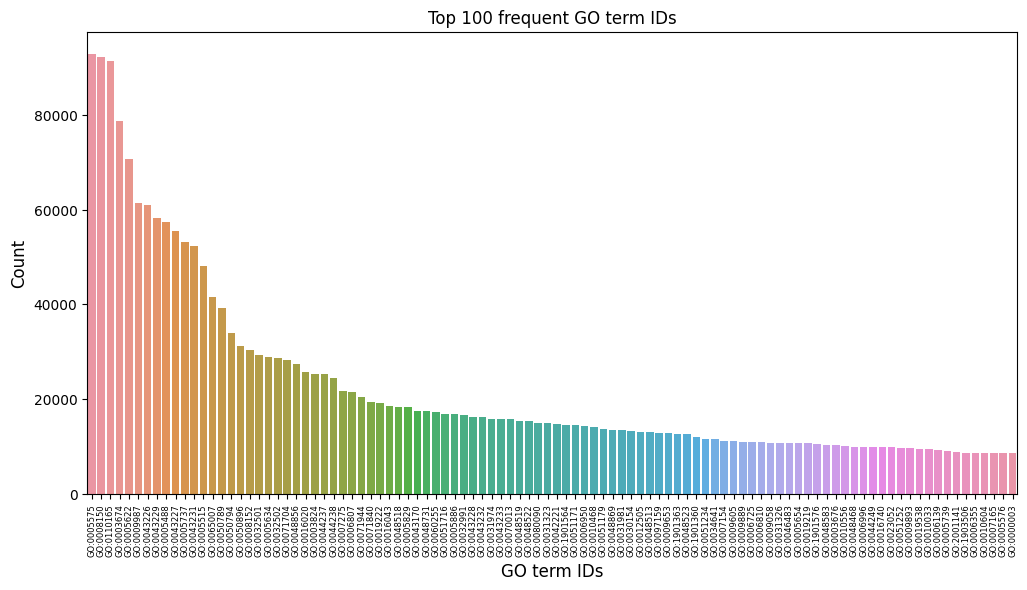

In [10]:
# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [11]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

In [12]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

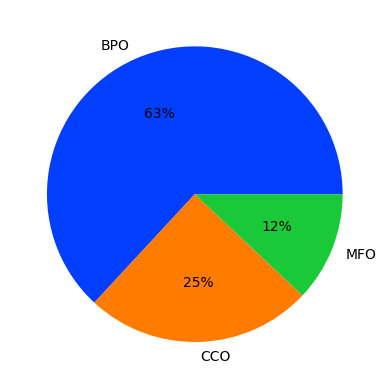

In [13]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [14]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    
    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar 
bar.finish()

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

[========================================================================] 100%


(142246, 1500)


In [15]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from sklearn.model_selection import train_test_split

# Step 1: Use NumPy arrays (do NOT convert to tf.Tensor yet)
X = train_df.values  # shape: (142246, 1024)
Y = train_labels     # shape: (142246, 1500)

In [17]:
# Step 2: Split the dataset using scikit-learn
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

In [18]:
# Step 3: Now convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val   = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val   = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test  = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [19]:
print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (115218, 1024), (115218, 1500)
Validation shape: (12803, 1024), (12803, 1500)
Test shape: (14225, 1024), (14225, 1500)


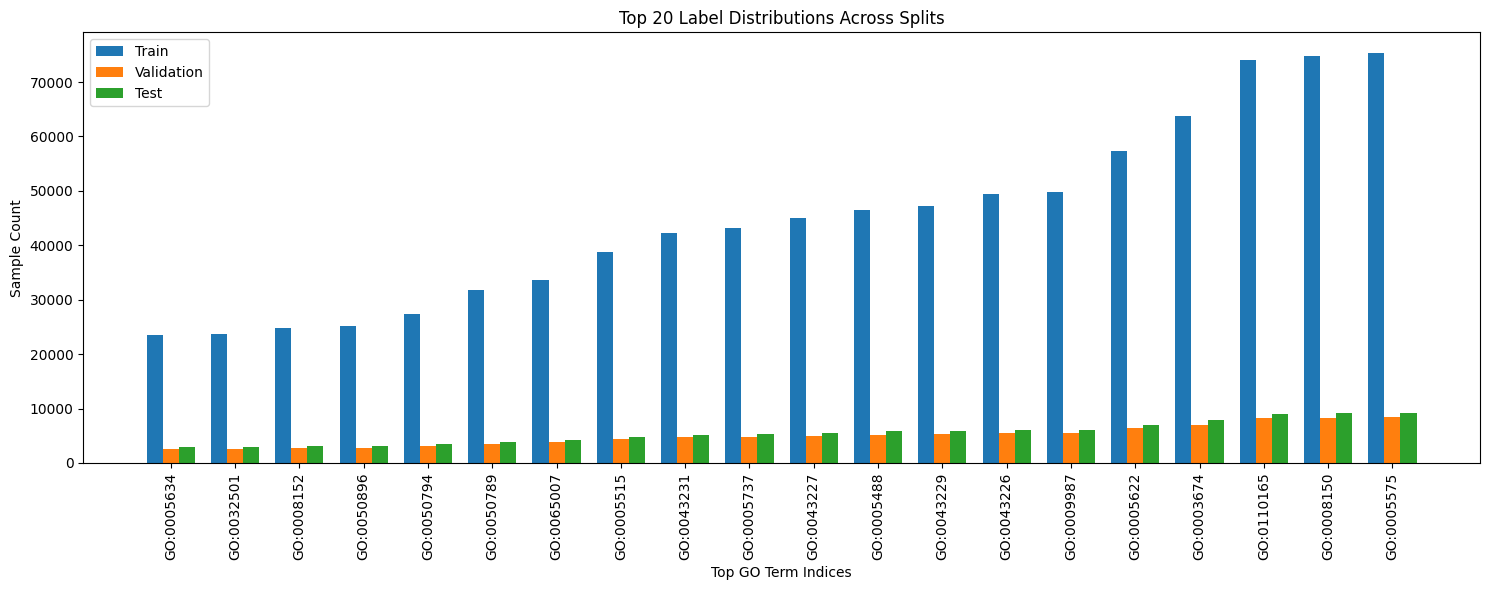

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Sum of labels for each split
train_label_counts = np.sum(y_train, axis=0)
val_label_counts = np.sum(y_val, axis=0)
test_label_counts = np.sum(y_test, axis=0)

# Select top 20 labels by frequency in training set for visualization
top_k = 20
top_indices = np.argsort(train_label_counts)[-top_k:]

# Plotting
x = np.arange(top_k)
width = 0.25

plt.figure(figsize=(15, 6))
plt.bar(x - width, train_label_counts[top_indices], width=width, label='Train')
plt.bar(x, val_label_counts[top_indices], width=width, label='Validation')
plt.bar(x + width, test_label_counts[top_indices], width=width, label='Test')

# Labeling
plt.xlabel('Top GO Term Indices')
plt.ylabel('Sample Count')
plt.title('Top 20 Label Distributions Across Splits')
plt.xticks(x, [labels[i] for i in top_indices], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

****1_GRU****

In [21]:
# ====== Reshape input for GRU ======
X_train_r = tf.expand_dims(X_train, axis=-1)
X_val_r   = tf.expand_dims(X_val, axis=-1)
X_test_r  = tf.expand_dims(X_test, axis=-1)

In [ ]:
from tensorflow.keras.layers import Input, GRU, Bidirectional, Dense, Dropout
# ====== Build GRU Model ======
def build_gru_model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim, 1)),
        Bidirectional(GRU(64, return_sequences=False)),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# ====== Instantiate and Train GRU ======
gru_model = build_gru_model(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
gru_model.summary()


In [26]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = gru_model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=5,
    batch_size=512,
    callbacks=[early_stop]
)

Epoch 1/5
226/226 [==============================] - 647s 3s/step - loss: 0.1541 - binary_accuracy: 0.9751 - auc: 0.7470 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8326
Epoch 2/5
226/226 [==============================] - 646s 3s/step - loss: 0.0787 - binary_accuracy: 0.9799 - auc: 0.8257 - val_loss: 0.0781 - val_binary_accuracy: 0.9799 - val_auc: 0.8324
Epoch 3/5
226/226 [==============================] - 636s 3s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8262 - val_loss: 0.0781 - val_binary_accuracy: 0.9799 - val_auc: 0.8318
Epoch 4/5
226/226 [==============================] - 659s 3s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8262 - val_loss: 0.0781 - val_binary_accuracy: 0.9799 - val_auc: 0.8323


In [27]:
gru_model.save('gru_model.h5')

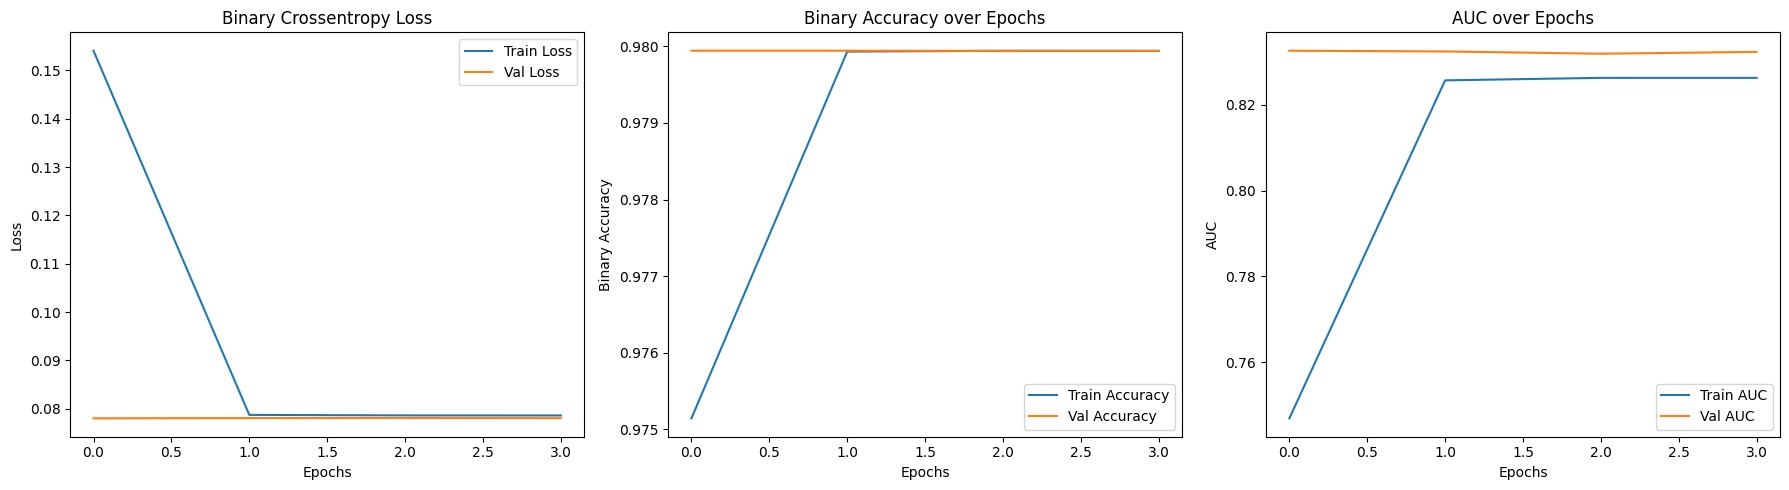

In [28]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# ====== Evaluate on Test Set ======
y_pred_proba = gru_model.predict(X_test_r)
y_pred_binary = (y_pred_proba >= 0.2).astype(int)

445/445 [==============================] - 60s 132ms/step


In [30]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy

In [30]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred_binary).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0781
Binary Accuracy: 0.9767
AUC:           0.8317
Precision:     0.3961
Recall:        0.2423
F1 Score:      0.3007
Hamming Loss:  0.0233
ROC-AUC:       0.8348
AUPR:          0.2362


**2. LSTM**

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, hamming_loss, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# ====== Build LSTM Model ======
def build_lstm_model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim, 1)),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# ====== Instantiate and Train LSTM ======
lstm_model = build_lstm_model(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 128)              33792     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1500)              193500    
                                                                 
Total params: 227,292
Trainable params: 227,292
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = lstm_model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=5,
    batch_size=512,
    callbacks=[early_stop]
)

Epoch 1/5
226/226 [==============================] - 795s 3s/step - loss: 0.1463 - binary_accuracy: 0.9765 - auc: 0.7449 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8326
Epoch 2/5
226/226 [==============================] - 806s 4s/step - loss: 0.0787 - binary_accuracy: 0.9799 - auc: 0.8260 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8325
Epoch 3/5
226/226 [==============================] - 799s 4s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8265 - val_loss: 0.0781 - val_binary_accuracy: 0.9799 - val_auc: 0.8327
Epoch 4/5
226/226 [==============================] - 806s 4s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8269 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8327
Epoch 5/5
226/226 [==============================] - 811s 4s/step - loss: 0.0785 - binary_accuracy: 0.9799 - auc: 0.8269 - val_loss: 0.0781 - val_binary_accuracy: 0.9799 - val_auc: 0.8324


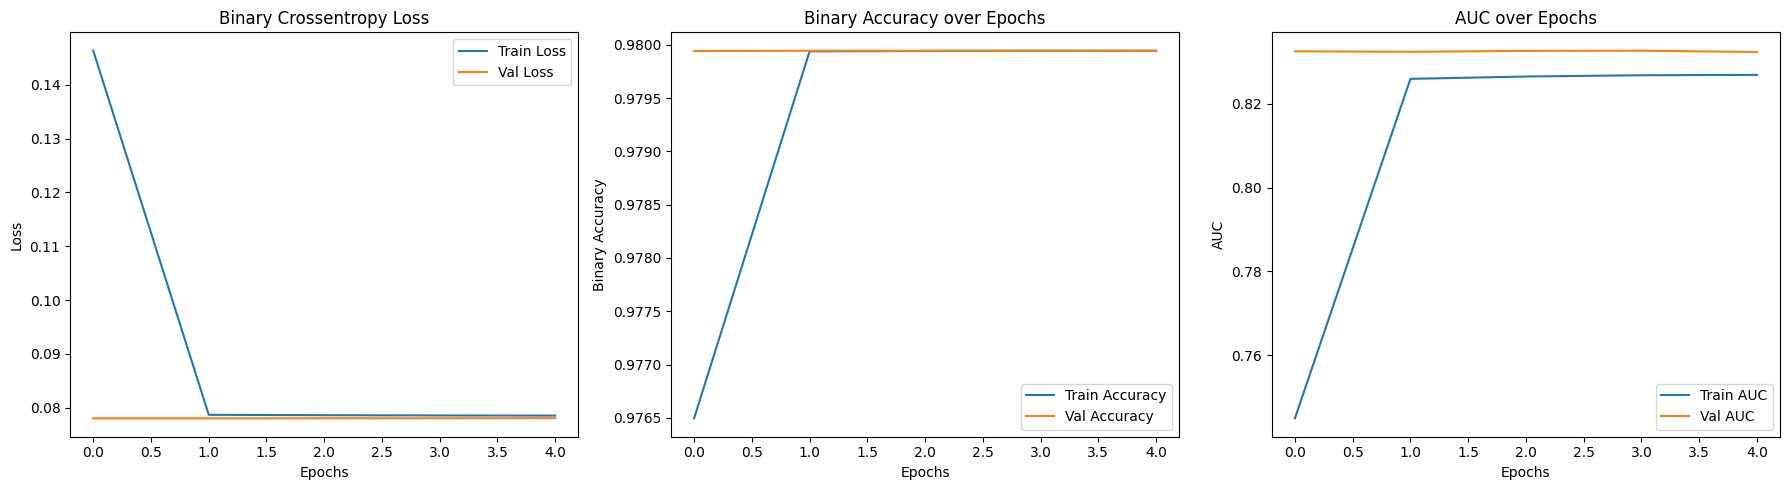

In [34]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
lstm_model.save('lstm_model.h5')

In [35]:
# ====== Evaluate on Test Set ======
y_pred_proba = lstm_model.predict(X_test_r)
y_pred_binary = (y_pred_proba >= 0.2).astype(int)

445/445 [==============================] - 87s 193ms/step


In [36]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred_binary).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0781
Binary Accuracy: 0.9771
AUC:           0.8317
Precision:     0.4070
Recall:        0.2358
F1 Score:      0.2986
Hamming Loss:  0.0229
ROC-AUC:       0.8348
AUPR:          0.2370


**3. BiLSTM**

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, hamming_loss, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

In [39]:
# ====== Build BiLSTM Model ======
def build_bilstm_model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim, 1)),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# ====== Instantiate and Train BiLSTM ======
bilstm_model = build_bilstm_model(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
bilstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 128)              33792     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1500)              193500    
                                                                 
Total params: 227,292
Trainable params: 227,292
Non-trainable params: 0
_________________________________________________________________


In [40]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = bilstm_model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=5,
    batch_size=512,
    callbacks=[early_stop]
)

Epoch 1/5
226/226 [==============================] - 819s 4s/step - loss: 0.1449 - binary_accuracy: 0.9763 - auc: 0.7458 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8326
Epoch 2/5
226/226 [==============================] - 804s 4s/step - loss: 0.0787 - binary_accuracy: 0.9799 - auc: 0.8261 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8327
Epoch 3/5
226/226 [==============================] - 802s 4s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8264 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8325
Epoch 4/5
226/226 [==============================] - 805s 4s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8269 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8324
Epoch 5/5
226/226 [==============================] - 814s 4s/step - loss: 0.0785 - binary_accuracy: 0.9799 - auc: 0.8270 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8324


In [41]:
bilstm_model.save('bilstm_model.h5')

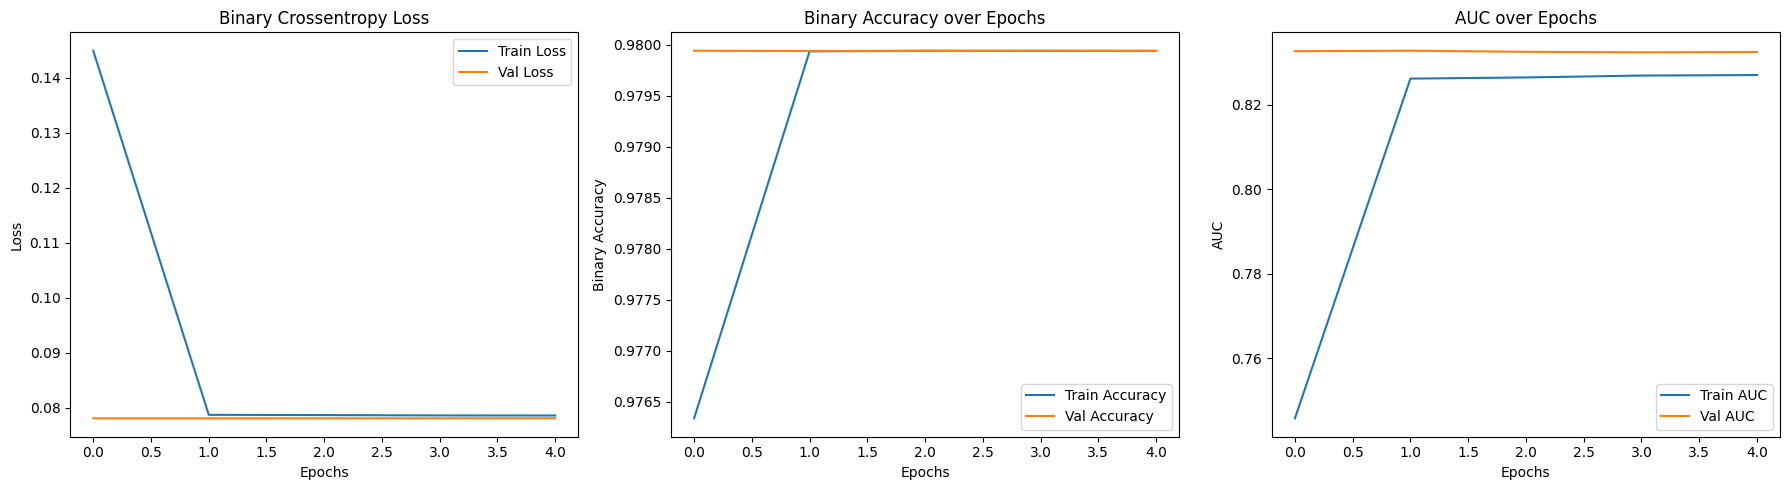

In [42]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
# ====== Evaluate on Test Set ======
y_pred_proba = bilstm_model.predict(X_test_r)
y_pred_binary = (y_pred_proba >= 0.2).astype(int)

445/445 [==============================] - 84s 186ms/step


In [44]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred_binary).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0781
Binary Accuracy: 0.9755
AUC:           0.8317
Precision:     0.3699
Recall:        0.2619
F1 Score:      0.3067
Hamming Loss:  0.0245
ROC-AUC:       0.8348
AUPR:          0.2366


**4. DNN**

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

In [46]:
# ====== Build DNN Model ======
def build_dnn_model(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(output_dim, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# ====== Train the DNN Model ======
dnn_model = build_dnn_model(X_train.shape[1], y_train.shape[1])
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1500)              385500    
                                                                 
Total params: 1,041,628
Trainable params: 1,041,628
Non-trainable params: 0
_________________________________________________________________


In [47]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = dnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=512,
    callbacks=[early_stop]
)

Epoch 1/5
226/226 [==============================] - 21s 87ms/step - loss: 0.1130 - binary_accuracy: 0.9717 - auc: 0.7801 - val_loss: 0.0758 - val_binary_accuracy: 0.9801 - val_auc: 0.8496
Epoch 2/5
226/226 [==============================] - 20s 88ms/step - loss: 0.0734 - binary_accuracy: 0.9802 - auc: 0.8652 - val_loss: 0.0689 - val_binary_accuracy: 0.9805 - val_auc: 0.8931
Epoch 3/5
226/226 [==============================] - 19s 85ms/step - loss: 0.0687 - binary_accuracy: 0.9805 - auc: 0.8940 - val_loss: 0.0659 - val_binary_accuracy: 0.9807 - val_auc: 0.9086
Epoch 4/5
226/226 [==============================] - 21s 94ms/step - loss: 0.0665 - binary_accuracy: 0.9806 - auc: 0.9048 - val_loss: 0.0644 - val_binary_accuracy: 0.9808 - val_auc: 0.9156
Epoch 5/5
226/226 [==============================] - 20s 89ms/step - loss: 0.0652 - binary_accuracy: 0.9807 - auc: 0.9110 - val_loss: 0.0635 - val_binary_accuracy: 0.9809 - val_auc: 0.9194


In [57]:
dnn_model.save('dnn_model.h5')

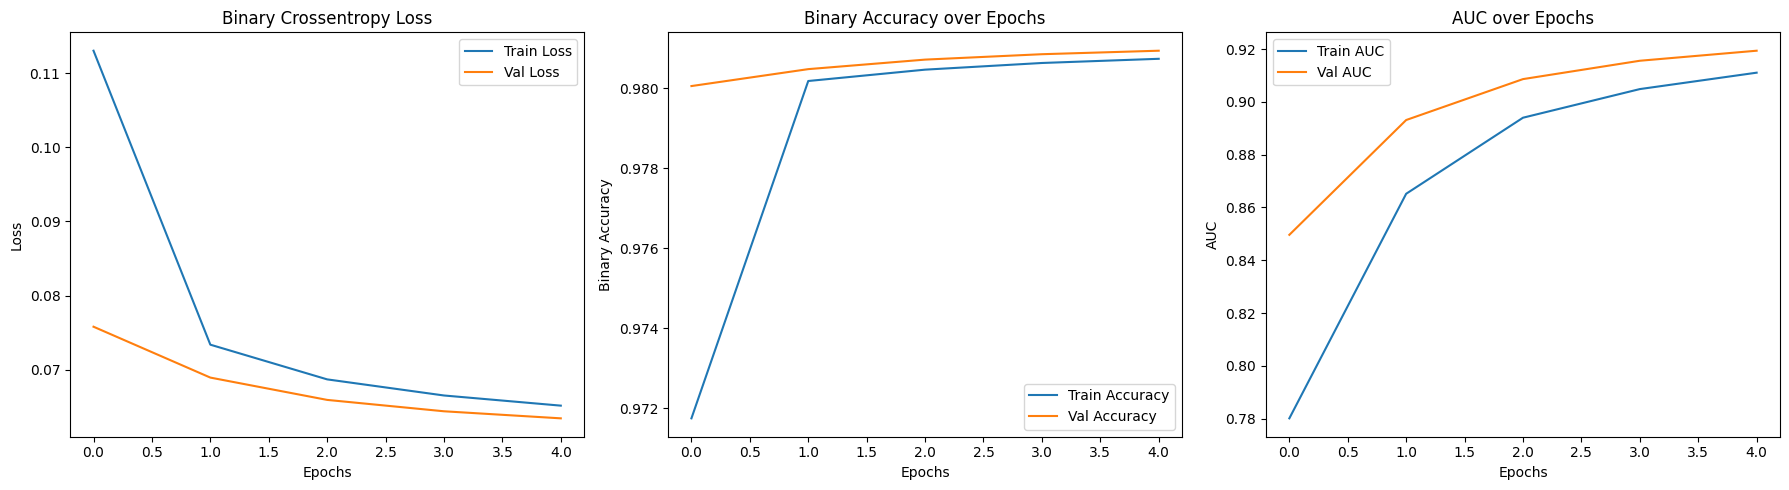

In [48]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
# ====== Evaluate on Test Set ======
y_pred_proba = dnn_model.predict(X_test)
y_pred_binary = (y_pred_proba >= 0.2).astype(int)

445/445 [==============================] - 2s 4ms/step


In [50]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred_binary).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0638
Binary Accuracy: 0.9757
AUC:           0.9180
Precision:     0.4127
Recall:        0.4105
F1 Score:      0.4116
Hamming Loss:  0.0243
ROC-AUC:       0.9239
AUPR:          0.3675


**5. BiLSTM + Attention Architecture**

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM, Layer
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score

In [52]:
# ===== Custom Attention Layer =====
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        score = tf.nn.tanh(inputs)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [53]:
# ===== Build BiLSTM + Attention Model =====
def build_bilstm_attention_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim, 1))
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = AttentionLayer()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_dim, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [54]:
# ===== Train Model =====
bilstm_att_model = build_bilstm_attention_model(X_train.shape[1], y_train.shape[1])
bilstm_att_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 1024, 128)        33792     
 nal)                                                            
                                                                 
 attention_layer (AttentionL  (None, 128)              0         
 ayer)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1500)              193500    
                                                                 
Total params: 227,292
Trainable params: 227,292
Non-trainable

In [55]:
history = bilstm_att_model.fit(X_train_r, y_train,
                               validation_data=(X_val_r, y_val),
                               epochs=5,
                               batch_size=512,
                               callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
226/226 [==============================] - 1506s 7s/step - loss: 0.1441 - binary_accuracy: 0.9766 - auc: 0.7458 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8327
Epoch 2/5
226/226 [==============================] - 1479s 7s/step - loss: 0.0787 - binary_accuracy: 0.9799 - auc: 0.8260 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8327
Epoch 3/5
226/226 [==============================] - 1464s 6s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8263 - val_loss: 0.0781 - val_binary_accuracy: 0.9799 - val_auc: 0.8324
Epoch 4/5
226/226 [==============================] - 1493s 7s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8267 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8325


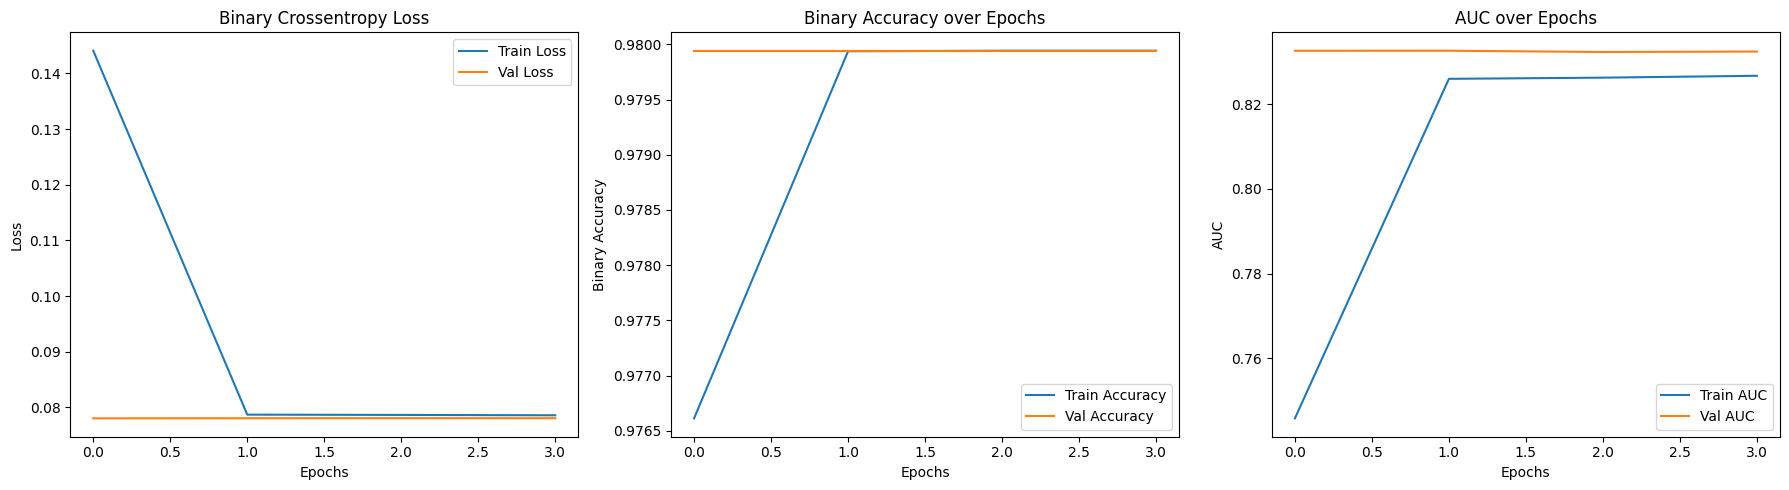

In [56]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
bilstm_att_model.save('bilstm_att_model.h5')

In [59]:
# ===== Evaluate on Test Set =====
y_pred = bilstm_att_model.predict(X_test_r)
y_pred_binary = (y_pred >= 0.2).astype(int)

445/445 [==============================] - 105s 233ms/step


In [60]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred_binary).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0638
Binary Accuracy: 0.9759
AUC:           0.9180
Precision:     0.3782
Recall:        0.2556
F1 Score:      0.3050
Hamming Loss:  0.0241
ROC-AUC:       0.9239
AUPR:          0.3675


**6. CNN + BiLSTM + Attention Architecture**

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

In [42]:
# ===== Custom Attention Layer =====
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        score = tf.nn.tanh(inputs)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [43]:
# ===== Build CNN + BiLSTM + Attention Model =====
def build_cnn_bilstm_attention_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim, 1))
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = AttentionLayer()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_dim, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [44]:
# ===== Train Model =====
cnn_bilstm_att_model = build_cnn_bilstm_attention_model(X_train.shape[1], y_train.shape[1])
cnn_bilstm_att_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1020, 64)          384       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 510, 64)          0         
 1D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 510, 64)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 510, 128)         66048     
 l)                                                              
                                                                 
 attention_layer_1 (Attentio  (None, 128)              0   

In [45]:
history = cnn_bilstm_att_model.fit(X_train_r, y_train,
                                   validation_data=(X_val_r, y_val),
                                   epochs=5,
                                   batch_size=512,
                                   callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
226/226 [==============================] - 1109s 5s/step - loss: 0.1413 - binary_accuracy: 0.9742 - auc: 0.7487 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8327
Epoch 2/5
226/226 [==============================] - 1113s 5s/step - loss: 0.0787 - binary_accuracy: 0.9799 - auc: 0.8262 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8324
Epoch 3/5
226/226 [==============================] - 1104s 5s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8265 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8323
Epoch 4/5
226/226 [==============================] - 1109s 5s/step - loss: 0.0785 - binary_accuracy: 0.9799 - auc: 0.8271 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8325
Epoch 5/5
226/226 [==============================] - 1111s 5s/step - loss: 0.0785 - binary_accuracy: 0.9799 - auc: 0.8272 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8327


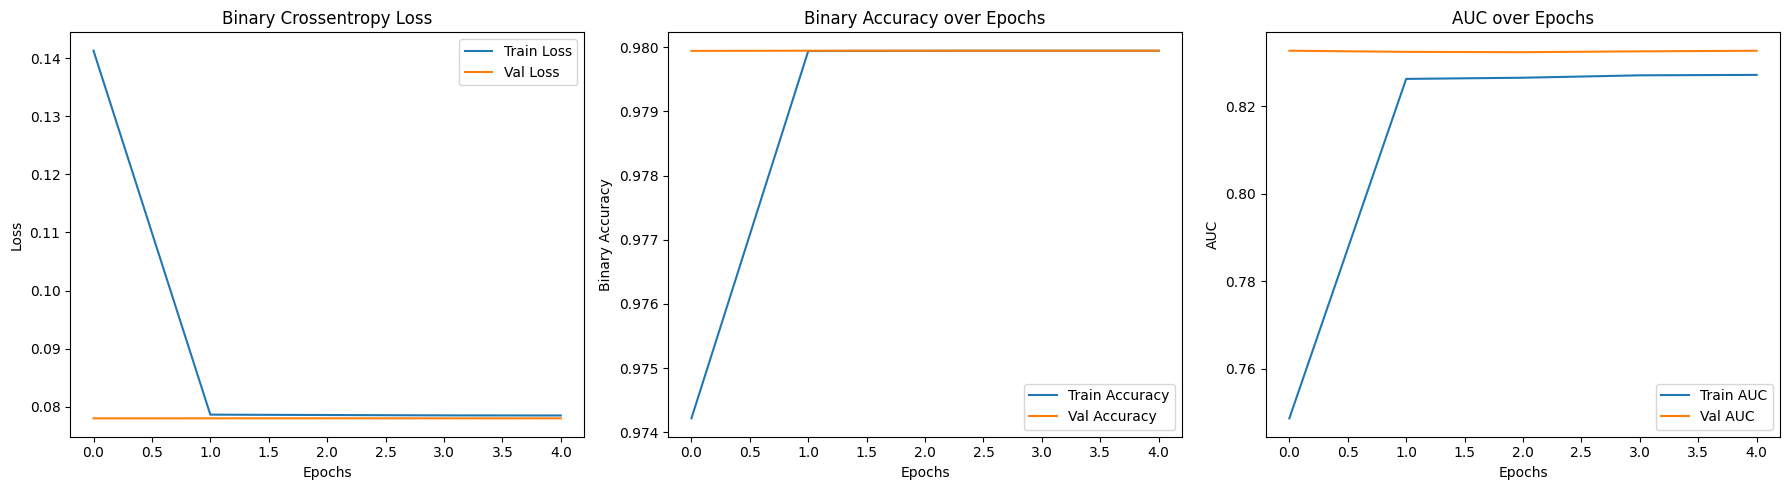

In [46]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
# ====== Evaluate on Test Set ======
y_pred_proba = cnn_bilstm_att_model.predict(X_test_r)
y_pred_binary = (y_pred_proba >= 0.2).astype(int)

445/445 [==============================] - 55s 122ms/step


In [48]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred_binary).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0781
Binary Accuracy: 0.9767
AUC:           0.8318
Precision:     0.3959
Recall:        0.2421
F1 Score:      0.3005
Hamming Loss:  0.0233
ROC-AUC:       0.8347
AUPR:          0.2363


**7. CNN + Attention Architecture**

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Dense, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

In [29]:
# ===== Custom Attention Layer =====
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        score = tf.nn.tanh(inputs)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

In [30]:
# ===== Build CNN + Attention Model =====
def build_cnn_attention_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim, 1))
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = AttentionLayer()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_dim, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [31]:
# ===== Train Model =====
cnn_att_model = build_cnn_attention_model(X_train.shape[1], y_train.shape[1])
cnn_att_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1020, 64)          384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 510, 64)          0         
 )                                                               
                                                                 
 dropout_12 (Dropout)        (None, 510, 64)           0         
                                                                 
 attention_layer (AttentionL  (None, 64)               0         
 ayer)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 64)                0   

In [32]:
history = cnn_att_model.fit(X_train_r, y_train,
                            validation_data=(X_val_r, y_val),
                            epochs=5,
                            batch_size=512,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/5
226/226 [==============================] - 248s 1s/step - loss: 0.3249 - binary_accuracy: 0.9760 - auc: 0.5972 - val_loss: 0.0962 - val_binary_accuracy: 0.9799 - val_auc: 0.8182
Epoch 2/5
226/226 [==============================] - 251s 1s/step - loss: 0.0824 - binary_accuracy: 0.9799 - auc: 0.7942 - val_loss: 0.0805 - val_binary_accuracy: 0.9799 - val_auc: 0.8318
Epoch 3/5
226/226 [==============================] - 244s 1s/step - loss: 0.0790 - binary_accuracy: 0.9799 - auc: 0.8185 - val_loss: 0.0791 - val_binary_accuracy: 0.9799 - val_auc: 0.8338
Epoch 4/5
226/226 [==============================] - 247s 1s/step - loss: 0.0787 - binary_accuracy: 0.9799 - auc: 0.8233 - val_loss: 0.0789 - val_binary_accuracy: 0.9799 - val_auc: 0.8336
Epoch 5/5
226/226 [==============================] - 259s 1s/step - loss: 0.0786 - binary_accuracy: 0.9799 - auc: 0.8257 - val_loss: 0.0788 - val_binary_accuracy: 0.9799 - val_auc: 0.8336


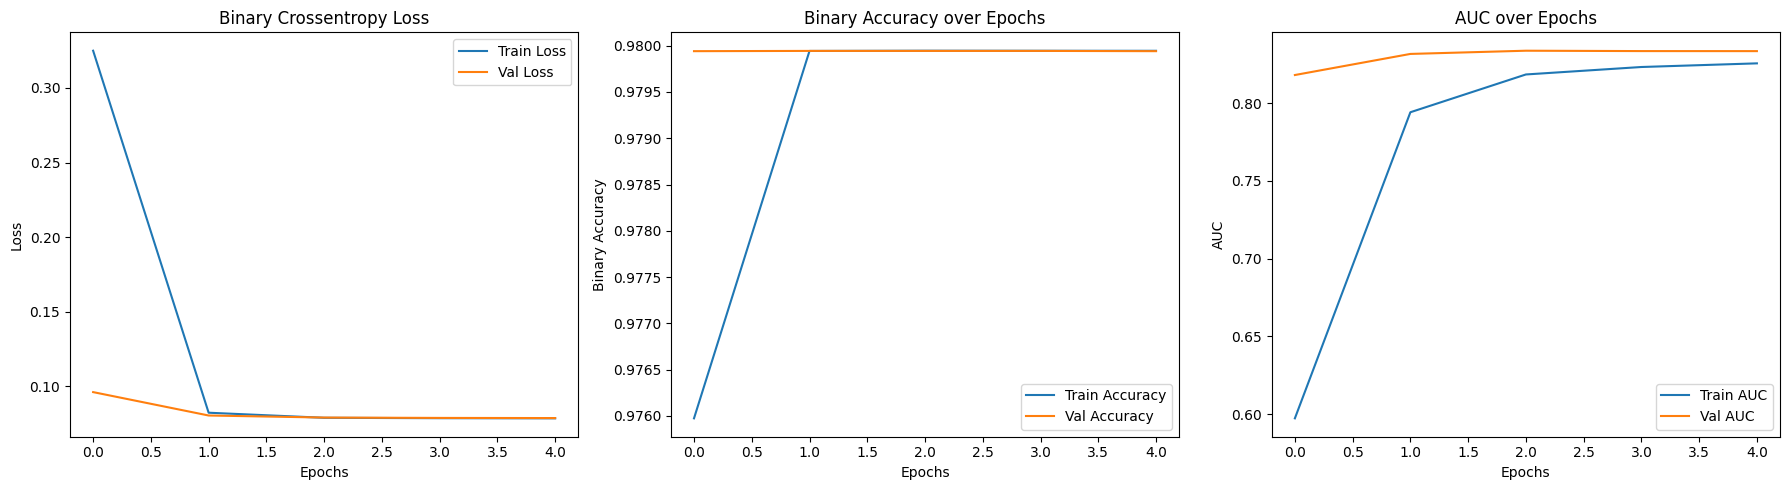

In [34]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# ===== Evaluate on Test Set =====
y_pred_proba = cnn_att_model.predict(X_test_r)
y_pred_binary = (y_pred_proba >= 0.2).astype(int)

445/445 [==============================] - 7s 16ms/step


In [40]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred_binary, average='micro')
recall = recall_score(y_test, y_pred_binary, average='micro')
f1 = f1_score(y_test, y_pred_binary, average='micro')
hamming = hamming_loss(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred_binary).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0789
Binary Accuracy: 0.9738
AUC:           0.8325
Precision:     0.3427
Recall:        0.2874
F1 Score:      0.3126
Hamming Loss:  0.0262
ROC-AUC:       0.8361
AUPR:          0.2367


**8. CNN + Multi-Head Attention**

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

In [23]:
# === Define CNN + Multi-Head Attention Model ===
def build_cnn_attention_model(input_dim, output_dim):
    inputs = tf.keras.Input(shape=(input_dim, 1))
    
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # Project to query/key/value
    x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [24]:
# === Build and Train ===
cnn_att_model = build_cnn_attention_model(X_train.shape[1], y_train.shape[1])
cnn_att_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 64)     256         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 512, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 multi_head_attention (MultiHea  (None, 512, 64)     16640       ['max_pooling1d[0][0]',          
 dAttention)                                                      'max_pooling1d[0][0]']      

In [25]:
history = cnn_att_model.fit(
    X_train_r, y_train,
    validation_data=(X_val_r, y_val),
    epochs=5,
    batch_size=512,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/5
226/226 [==============================] - 2781s 12s/step - loss: 0.1751 - binary_accuracy: 0.9759 - auc: 0.7173 - val_loss: 0.0779 - val_binary_accuracy: 0.9799 - val_auc: 0.8335
Epoch 2/5
226/226 [==============================] - 2843s 13s/step - loss: 0.0789 - binary_accuracy: 0.9799 - auc: 0.8239 - val_loss: 0.0779 - val_binary_accuracy: 0.9799 - val_auc: 0.8334
Epoch 3/5
226/226 [==============================] - 2849s 13s/step - loss: 0.0788 - binary_accuracy: 0.9799 - auc: 0.8246 - val_loss: 0.0779 - val_binary_accuracy: 0.9799 - val_auc: 0.8335
Epoch 4/5
226/226 [==============================] - 2789s 12s/step - loss: 0.0788 - binary_accuracy: 0.9799 - auc: 0.8249 - val_loss: 0.0780 - val_binary_accuracy: 0.9799 - val_auc: 0.8333


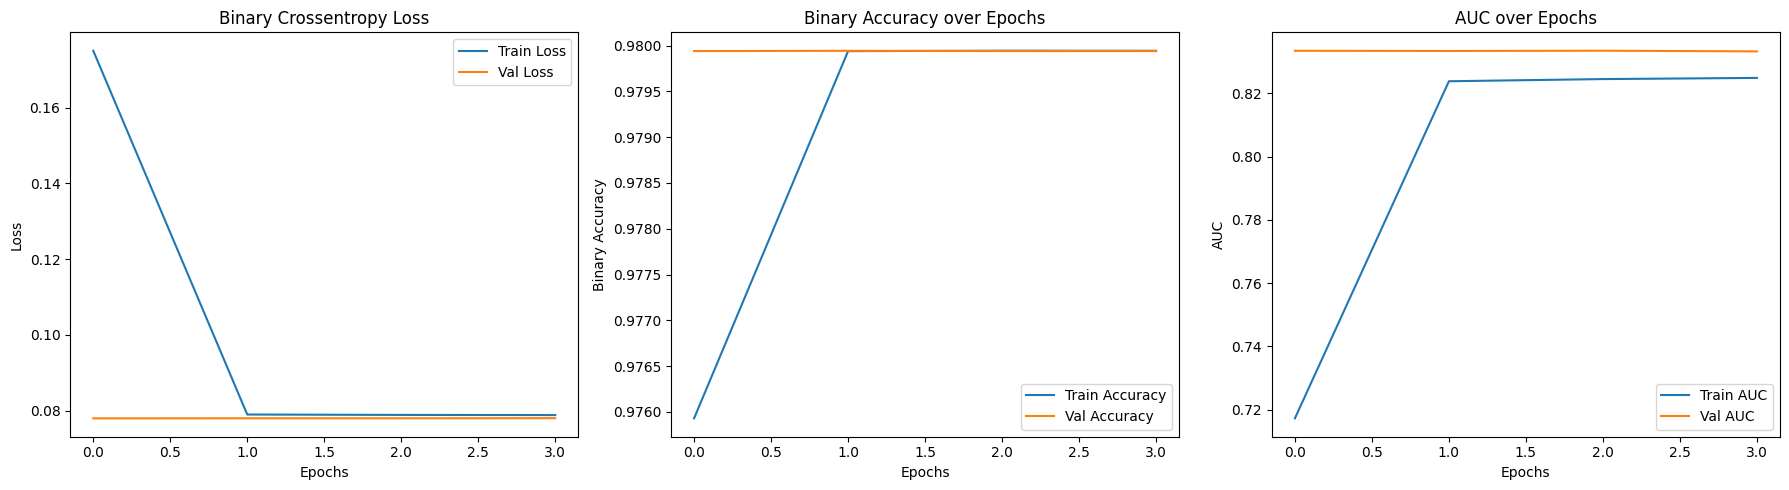

In [26]:
# ====== Plot Training History ======
plt.figure(figsize=(18, 5))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Binary Crossentropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 2. Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title("Binary Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary Accuracy")
plt.legend()

# 3. AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title("AUC over Epochs")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# === Plot Loss and AUC ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.title("CNN + Multi-Head Attention")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()

In [27]:
# === Test Evaluation ===
y_pred_proba = cnn_att_model.predict(X_test_r)
y_pred = (y_pred_proba > 0.2).astype(int)

445/445 [==============================] - 181s 405ms/step


In [31]:
# Calculate traditional evaluation metrics
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
aupr = average_precision_score(y_test, y_pred_proba, average='micro')

# Also compute loss, binary accuracy, and AUC for consistency
loss_fn = BinaryCrossentropy()
binary_accuracy_metric = BinaryAccuracy()
auc_metric = AUC()

test_loss = loss_fn(y_test, y_pred_proba).numpy()
binary_accuracy = binary_accuracy_metric(y_test, y_pred).numpy()
auc_value = auc_metric(y_test, y_pred_proba).numpy()

# Print all evaluation results
print(f"\n===== Final Model Test Evaluation =====")
print(f"Loss:          {test_loss:.4f}")
print(f"Binary Accuracy: {binary_accuracy:.4f}")
print(f"AUC:           {auc_value:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"Hamming Loss:  {hamming:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print(f"AUPR:          {aupr:.4f}")


===== Final Model Test Evaluation =====
Loss:          0.0780
Binary Accuracy: 0.9768
AUC:           0.8324
Precision:     0.3994
Recall:        0.2414
F1 Score:      0.3009
Hamming Loss:  0.0232
ROC-AUC:       0.8360
AUPR:          0.2369


**9. Enhanced DNN architecture**

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Multiply, Softmax
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow_addons.optimizers import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [23]:
# ===== Enhanced DNN Model with Attention on Output =====
def build_advanced_dnn(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(1024, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    raw_outputs = Dense(output_dim)(x)

    # Output attention for label correlation modeling
    attention_weights = Softmax(name="output_attention")(raw_outputs)
    outputs = Multiply()([raw_outputs, attention_weights])
    outputs = tf.keras.activations.sigmoid(outputs)

    model = Model(inputs=inputs, outputs=outputs)

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.9
    )
    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [24]:
# ===== Build Sample Model & Show Summary =====
sample_model = build_advanced_dnn(X_train.shape[1], y_train.shape[1])
sample_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         1049600     ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024)        4096        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 1024)         0           ['batch_normalization[0][0]']

In [25]:
# ===== Ensemble Training (3 Models Averaged) =====
models = [build_advanced_dnn(X_train.shape[1], y_train.shape[1]) for _ in range(3)]
histories = []

for i, model in enumerate(models):
    print(f"\nTraining model {i+1}/3...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=512,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
    )
    histories.append(history)


Training model 1/3...
Epoch 1/5
226/226 [==============================] - 34s 140ms/step - loss: 0.6931 - binary_accuracy: 0.6155 - auc: 0.5086 - val_loss: 0.6927 - val_binary_accuracy: 0.9779 - val_auc: 0.5148
Epoch 2/5
226/226 [==============================] - 31s 139ms/step - loss: 0.6913 - binary_accuracy: 0.7773 - auc: 0.5472 - val_loss: 0.6865 - val_binary_accuracy: 0.8874 - val_auc: 0.7148
Epoch 3/5
226/226 [==============================] - 31s 136ms/step - loss: 0.6818 - binary_accuracy: 0.7853 - auc: 0.6785 - val_loss: 0.6727 - val_binary_accuracy: 0.7942 - val_auc: 0.7414
Epoch 4/5
226/226 [==============================] - 32s 143ms/step - loss: 0.6650 - binary_accuracy: 0.8230 - auc: 0.7259 - val_loss: 0.6546 - val_binary_accuracy: 0.8251 - val_auc: 0.7571
Epoch 5/5
226/226 [==============================] - 33s 148ms/step - loss: 0.6469 - binary_accuracy: 0.8457 - auc: 0.7497 - val_loss: 0.6382 - val_binary_accuracy: 0.8312 - val_auc: 0.7626

Training model 2/3...
Epoc

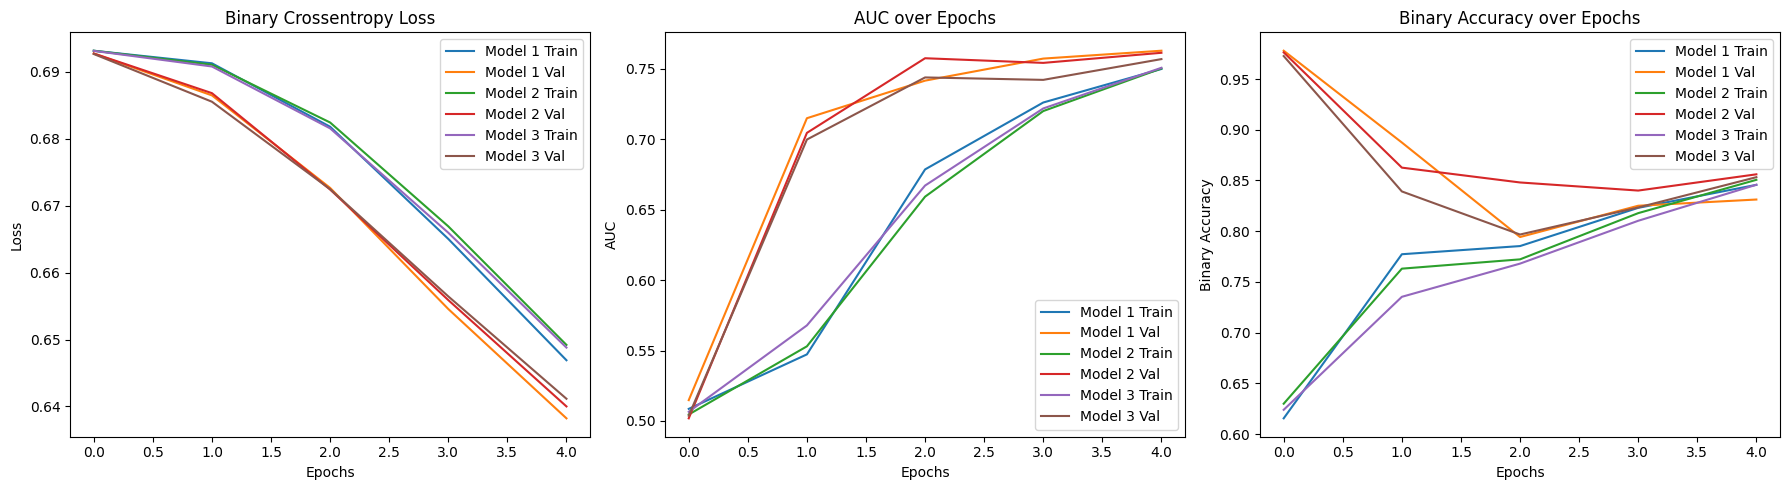

In [26]:
# ===== Plot Loss, AUC, and Binary Accuracy =====
def plot_history(histories):
    plt.figure(figsize=(18, 5))
    
    for i, history in enumerate(histories):
        # Loss
        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label=f'Model {i+1} Train')
        plt.plot(history.history['val_loss'], label=f'Model {i+1} Val')
        plt.title('Binary Crossentropy Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # AUC
        plt.subplot(1, 3, 2)
        plt.plot(history.history['auc'], label=f'Model {i+1} Train')
        plt.plot(history.history['val_auc'], label=f'Model {i+1} Val')
        plt.title('AUC over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        # Binary Accuracy
        plt.subplot(1, 3, 3)
        plt.plot(history.history['binary_accuracy'], label=f'Model {i+1} Train')
        plt.plot(history.history['val_binary_accuracy'], label=f'Model {i+1} Val')
        plt.title('Binary Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Binary Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(histories)

In [27]:
# ===== Ensemble Prediction and Evaluation on Test Set =====
# Evaluate each model on the test set
losses = []
binary_accuracies = []
aucs = []

for model in models:
    results = model.evaluate(X_test, y_test, verbose=0)
    # Assuming: [loss, binary_accuracy, auc]
    losses.append(results[0])
    binary_accuracies.append(results[1])
    aucs.append(results[2])

# Average the evaluation metrics across models
avg_loss = np.mean(losses)
avg_binary_accuracy = np.mean(binary_accuracies)
avg_auc = np.mean(aucs)

# Ensemble prediction (mean of model outputs)
ensemble_preds = np.mean([model.predict(X_test) for model in models], axis=0)
binary_preds = (ensemble_preds >= 0.2).astype(int)

# Evaluation metrics
precision = precision_score(y_test, binary_preds, average='samples')
recall = recall_score(y_test, binary_preds, average='samples')
f1 = f1_score(y_test, binary_preds, average='samples')
hamming = hamming_loss(y_test, binary_preds)
roc_auc = roc_auc_score(y_test, ensemble_preds, average='macro')
aupr = average_precision_score(y_test, ensemble_preds, average='macro')

# Print all metrics
print(f"\n===== Ensemble Model Test Evaluation =====")
print(f"Loss:            {avg_loss:.4f}")
print(f"Binary Accuracy: {avg_binary_accuracy:.4f}")
print(f"AUC:             {avg_auc:.4f}")
print(f"Precision:       {precision:.4f}")
print(f"Recall:          {recall:.4f}")
print(f"F1 Score:        {f1:.4f}")
print(f"Hamming Loss:    {hamming:.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")
print(f"AUPR:            {aupr:.4f}")

445/445 [==============================] - 3s 6ms/step

===== Ensemble Model Test Evaluation =====
Loss:            0.6397
Binary Accuracy: 0.8499
AUC:             0.7601
Precision:       0.0207
Recall:          1.0000
F1 Score:        0.0397
Hamming Loss:    0.9793
ROC-AUC:         0.6340
AUPR:            0.0293


**Comparision**

**📘 1. Training Performance over Epochs (loss, binary_accuracy, AUC)**

In [56]:
# Sample structure: you can add full epoch-wise data per model
training_data = {
    'Epoch': [1, 2, 3, 4, 5],

    'GRU_loss':            [0.1541, 0.0787, 0.0786 , 0.0786, None],
    'GRU_binary_acc':      [0.9751, 0.9799, 0.9799, 0.9799, None],
    'GRU_auc':             [0.7470, 0.8257, 0.8262, 0.8262, None],

    'LSTM_loss':           [0.1463, 0.0787, 0.0786, 0.0786, 0.0785],
    'LSTM_binary_acc':     [0.9765, 0.9799, 0.9799, 0.9799, 0.9799],
    'LSTM_auc':            [0.7449, 0.8260, 0.8265, 0.8269, 0.8269],
    
    'BiLSTM_loss':         [0.1449, 0.0787, 0.0786, 0.0786, 0.0785],
    'BiLSTM_binary_acc':   [0.9763, 0.9799, 0.9799, 0.9799, 0.9799],
    'BiLSTM_auc':          [0.7458, 0.8261, 0.8264, 0.8269, 0.8270],
    
    'DNN_loss':            [0.1130, 0.0734, 0.0687, 0.0665, 0.0652],
    'DNN_binary_acc':      [0.9717, 0.9802, 0.9805, 0.9806, 0.9807],
    'DNN_auc':             [0.7801, 0.8652, 0.8940, 0.9048, 0.9110],
    
    'BiLSTM_Attn_loss':    [0.1441, 0.0787, 0.0786, 0.0786, None],
    'BiLSTM_Attn_binary_acc': [0.9766, 0.9799, 0.9799, 0.9799, None],
    'BiLSTM_Attn_auc':     [0.7458, 0.8260, 0.8263, 0.8267, None],
    
    'CNN_BiLSTM_Attn_loss':[0.1413, 0.0787, 0.0786, 0.0785, 0.0785],
    'CNN_BiLSTM_Attn_binary_acc':[0.9742, 0.9799, 0.9799, 0.9799, 0.9799],
    'CNN_BiLSTM_Attn_auc': [0.7487, 0.8262, 0.8265, 0.8271, 0.8272],
    
    'CNN_Attn_loss':       [0.3249, 0.0824, 0.0790, 0.0787, 0.0786],
    'CNN_Attn_binary_acc': [0.9760, 0.9799, 0.9799, 0.9799, 0.9799],
    'CNN_Attn_auc':        [0.5972, 0.7942, 0.8185, 0.8233, 0.8257],
    
    'CNN_MHA_loss':        [0.1751, 0.0789, 0.0788, 0.0788, None],
    'CNN_MHA_binary_acc':  [0.9759, 0.9799, 0.9799, 0.9799, None],
    'CNN_MHA_auc':         [0.7173, 0.8239, 0.8246, 0.8249, None],
}

df_train = pd.DataFrame(training_data)

In [57]:
df_train

,Epoch,GRU_loss,GRU_binary_acc,GRU_auc,LSTM_loss,LSTM_binary_acc,LSTM_auc,BiLSTM_loss,BiLSTM_binary_acc,BiLSTM_auc,...,BiLSTM_Attn_auc,CNN_BiLSTM_Attn_loss,CNN_BiLSTM_Attn_binary_acc,CNN_BiLSTM_Attn_auc,CNN_Attn_loss,CNN_Attn_binary_acc,CNN_Attn_auc,CNN_MHA_loss,CNN_MHA_binary_acc,CNN_MHA_auc
0,1,0.1541,0.9751,0.7470,0.1463,0.9765,0.7449,0.1449,0.9763,0.7458,...,0.7458,0.1413,0.9742,0.7487,0.3249,0.9760,0.5972,0.1751,0.9759,0.7173
1,2,0.0787,0.9799,0.8257,0.0787,0.9799,0.8260,0.0787,0.9799,0.8261,...,0.8260,0.0787,0.9799,0.8262,0.0824,0.9799,0.7942,0.0789,0.9799,0.8239
2,3,0.0786,0.9799,0.8262,0.0786,0.9799,0.8265,0.0786,0.9799,0.8264,...,0.8263,0.0786,0.9799,0.8265,0.0790,0.9799,0.8185,0.0788,0.9799,0.8246
3,4,0.0786,0.9799,0.8262,0.0786,0.9799,0.8269,0.0786,0.9799,0.8269,...,0.8267,0.0785,0.9799,0.8271,0.0787,0.9799,0.8233,0.0788,0.9799,0.8249
4,5,NaN,NaN,NaN,0.0785,0.9799,0.8269,0.0785,0.9799,0.8270,...,NaN,0.0785,0.9799,0.8272,0.0786,0.9799,0.8257,NaN,NaN,NaN


**📙 2. Validation Performance over Epochs**

In [58]:
validation_data = {
    'Epoch': [1, 2, 3, 4, 5],

    'GRU_val_loss':            [0.0780, 0.0781, 0.0781, 0.0781, None],
    'GRU_val_bi_acc':          [0.9799] * 5,
    'GRU_val_auc':             [0.8326, 0.8324, 0.8318, 0.8323, None],

    'LSTM_val_loss':           [0.0780, 0.0780, 0.0781, 0.0780, 0.0781],
    'LSTM_val_bi_acc':            [0.9799] * 5,
    'LSTM_val_auc':            [0.8326, 0.8325, 0.8327, 0.8327, 0.8324],

    'BiLSTM_val_loss':         [0.0780] * 5,
    'BiLSTM_val_bi_acc':          [0.9799] * 5,
    'BiLSTM_val_auc':          [0.8326, 0.8327, 0.8325, 0.8324, 0.8324],

    'DNN_val_loss':            [0.0758, 0.0689, 0.0659, 0.0644, 0.0635],
    'DNN_val_bi_acc':             [0.9799] * 5,
    'DNN_val_auc':             [0.9801, 0.9805, 0.9807, 0.9808, 0.9809],

    'BiLSTM_Attn_val_loss':    [0.0780, 0.0780, 0.0781, 0.0780, None],
    'BiLSTM_Attn_val_bi_acc':     [0.9799] * 4 + [None],
    'BiLSTM_Attn_val_auc':     [0.8327, 0.8327, 0.8324, 0.8325, None],

    'CNN_BiLSTM_Attn_val_loss':[0.0780] * 5,
    'CNN_BiLSTM_Attn_val_bi_acc': [0.9799] * 5,
    'CNN_BiLSTM_Attn_val_auc': [0.8327, 0.8324, 0.8323, 0.8325, 0.8327],

    'CNN_Attn_val_loss':       [0.0962, 0.0805, 0.0791, 0.0789, 0.0788],
    'CNN_Attn_val_bi_acc':        [0.9799] * 5,
    'CNN_Attn_val_auc':        [0.8182, 0.8318, 0.8338, 0.8336, 0.8336],

    'CNN_MHA_val_loss':        [0.0779, 0.0779, 0.0779, 0.0780, None],
    'CNN_MHA_val_bi_acc':         [0.9799] * 4 + [None],
    'CNN_MHA_val_auc':         [0.8335, 0.8334, 0.8335, 0.8333, None],
}

df_val = pd.DataFrame(validation_data)

In [59]:
df_val

,Epoch,GRU_val_loss,GRU_val_bi_acc,GRU_val_auc,LSTM_val_loss,LSTM_val_bi_acc,LSTM_val_auc,BiLSTM_val_loss,BiLSTM_val_bi_acc,BiLSTM_val_auc,...,BiLSTM_Attn_val_auc,CNN_BiLSTM_Attn_val_loss,CNN_BiLSTM_Attn_val_bi_acc,CNN_BiLSTM_Attn_val_auc,CNN_Attn_val_loss,CNN_Attn_val_bi_acc,CNN_Attn_val_auc,CNN_MHA_val_loss,CNN_MHA_val_bi_acc,CNN_MHA_val_auc
0,1,0.0780,0.9799,0.8326,0.0780,0.9799,0.8326,0.078,0.9799,0.8326,...,0.8327,0.078,0.9799,0.8327,0.0962,0.9799,0.8182,0.0779,0.9799,0.8335
1,2,0.0781,0.9799,0.8324,0.0780,0.9799,0.8325,0.078,0.9799,0.8327,...,0.8327,0.078,0.9799,0.8324,0.0805,0.9799,0.8318,0.0779,0.9799,0.8334
2,3,0.0781,0.9799,0.8318,0.0781,0.9799,0.8327,0.078,0.9799,0.8325,...,0.8324,0.078,0.9799,0.8323,0.0791,0.9799,0.8338,0.0779,0.9799,0.8335
3,4,0.0781,0.9799,0.8323,0.0780,0.9799,0.8327,0.078,0.9799,0.8324,...,0.8325,0.078,0.9799,0.8325,0.0789,0.9799,0.8336,0.0780,0.9799,0.8333
4,5,NaN,0.9799,NaN,0.0781,0.9799,0.8324,0.078,0.9799,0.8324,...,NaN,0.078,0.9799,0.8327,0.0788,0.9799,0.8336,NaN,NaN,NaN


**📗 3. Final Test Evaluation of All Models**

In [60]:
test_data = {
    'Model': [
        'GRU', 'LSTM', 'BiLSTM', 'DNN',
        'BiLSTM + Attention', 'CNN + BiLSTM + Attention',
        'CNN + Attention', 'CNN + Multi-Head Attention'
    ],
    
    'Loss':        [0.0781, 0.0781, 0.0781, 0.0638, 0.0638, 0.0781, 0.0789, 0.0780],
    'Binary Acc':  [0.9767, 0.9771, 0.9755, 0.9757, 0.9759, 0.9767, 0.9738, 0.9768],
    'AUC':         [0.8317, 0.8317, 0.8317, 0.9180, 0.9180, 0.8318, 0.8325, 0.8324],
    'Precision':   [0.3961, 0.4070, 0.3699, 0.4127, 0.3782, 0.3959, 0.3427, 0.3994],
    'Recall':      [0.2423, 0.2358, 0.2619, 0.4105, 0.2556, 0.2421, 0.2874, 0.2414],
    'F1 Score':    [0.3007, 0.2986, 0.3067, 0.4116, 0.3050, 0.3005, 0.3126, 0.3009],
    'Hamming Loss':[0.0233, 0.0229, 0.0245, 0.0243, 0.0241, 0.0233, 0.0262, 0.0232],
    'ROC-AUC':     [0.8348, 0.8348, 0.8348, 0.9239, 0.9239, 0.8347, 0.8361, 0.8360],
    'AUPR':        [0.2362, 0.2370, 0.2366, 0.3675, 0.3675, 0.2363, 0.2367, 0.2369],
}

df_test = pd.DataFrame(test_data)

In [61]:
df_test

,Model,Loss,Binary Acc,AUC,Precision,Recall,F1 Score,Hamming Loss,ROC-AUC,AUPR
0,GRU,0.0781,0.9767,0.8317,0.3961,0.2423,0.3007,0.0233,0.8348,0.2362
1,LSTM,0.0781,0.9771,0.8317,0.4070,0.2358,0.2986,0.0229,0.8348,0.2370
2,BiLSTM,0.0781,0.9755,0.8317,0.3699,0.2619,0.3067,0.0245,0.8348,0.2366
3,DNN,0.0638,0.9757,0.9180,0.4127,0.4105,0.4116,0.0243,0.9239,0.3675
4,BiLSTM + Attention,0.0638,0.9759,0.9180,0.3782,0.2556,0.3050,0.0241,0.9239,0.3675
5,CNN + BiLSTM + Attention,0.0781,0.9767,0.8318,0.3959,0.2421,0.3005,0.0233,0.8347,0.2363
6,CNN + Attention,0.0789,0.9738,0.8325,0.3427,0.2874,0.3126,0.0262,0.8361,0.2367
7,CNN + Multi-Head Attention,0.0780,0.9768,0.8324,0.3994,0.2414,0.3009,0.0232,0.8360,0.2369


**📊 Visualization of Training Loss and Binary Accuracy**

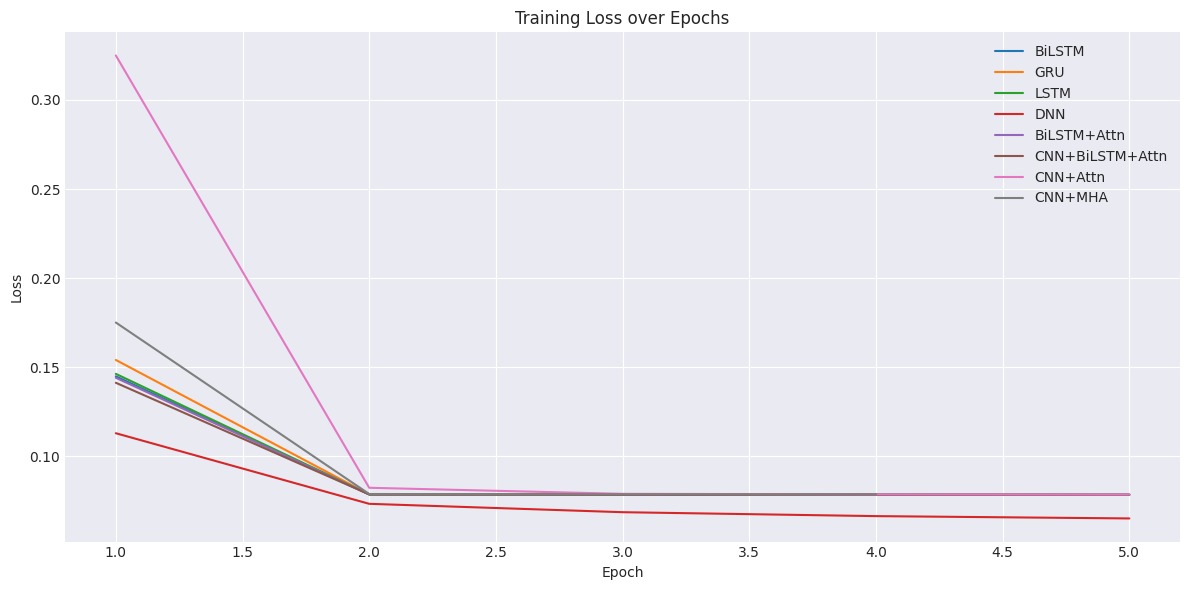

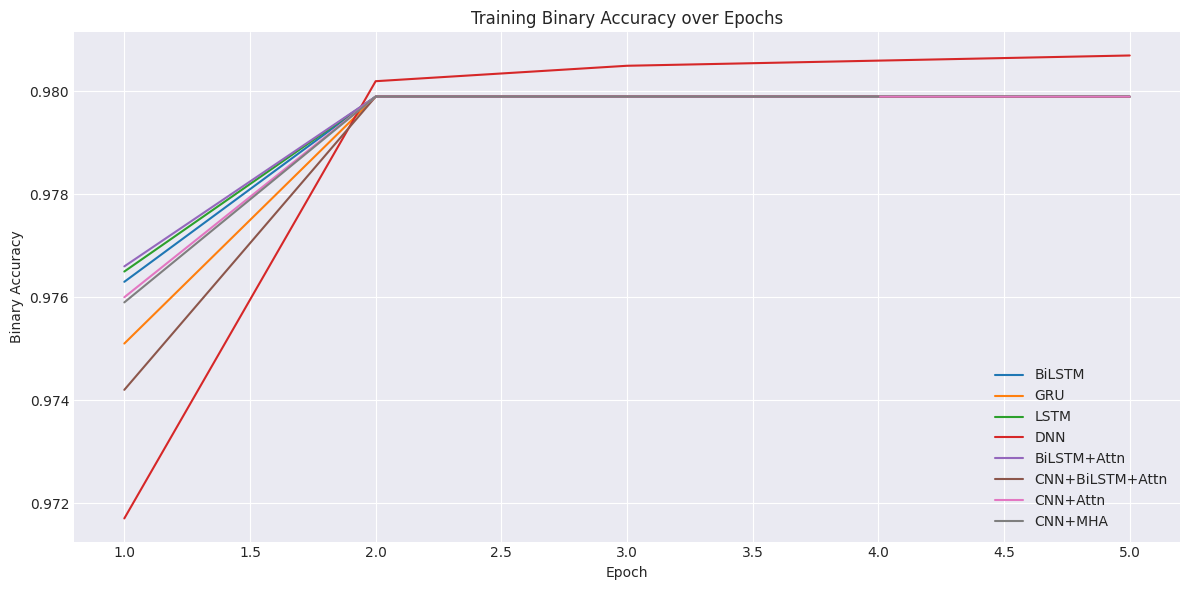

In [63]:
# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(df_train['Epoch'], df_train['BiLSTM_loss'], label='BiLSTM')
plt.plot(df_train['Epoch'], df_train['GRU_loss'], label='GRU')
plt.plot(df_train['Epoch'], df_train['LSTM_loss'], label='LSTM')
plt.plot(df_train['Epoch'], df_train['DNN_loss'], label='DNN')
plt.plot(df_train['Epoch'], df_train['BiLSTM_Attn_loss'], label='BiLSTM+Attn')
plt.plot(df_train['Epoch'], df_train['CNN_BiLSTM_Attn_loss'], label='CNN+BiLSTM+Attn')
plt.plot(df_train['Epoch'], df_train['CNN_Attn_loss'], label='CNN+Attn')
plt.plot(df_train['Epoch'], df_train['CNN_MHA_loss'], label='CNN+MHA')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training Binary Accuracy
plt.figure(figsize=(12, 6))
plt.plot(df_train['Epoch'], df_train['BiLSTM_binary_acc'], label='BiLSTM')
plt.plot(df_train['Epoch'], df_train['GRU_binary_acc'], label='GRU')
plt.plot(df_train['Epoch'], df_train['LSTM_binary_acc'], label='LSTM')
plt.plot(df_train['Epoch'], df_train['DNN_binary_acc'], label='DNN')
plt.plot(df_train['Epoch'], df_train['BiLSTM_Attn_binary_acc'], label='BiLSTM+Attn')
plt.plot(df_train['Epoch'], df_train['CNN_BiLSTM_Attn_binary_acc'], label='CNN+BiLSTM+Attn')
plt.plot(df_train['Epoch'], df_train['CNN_Attn_binary_acc'], label='CNN+Attn')
plt.plot(df_train['Epoch'], df_train['CNN_MHA_binary_acc'], label='CNN+MHA')
plt.title('Training Binary Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

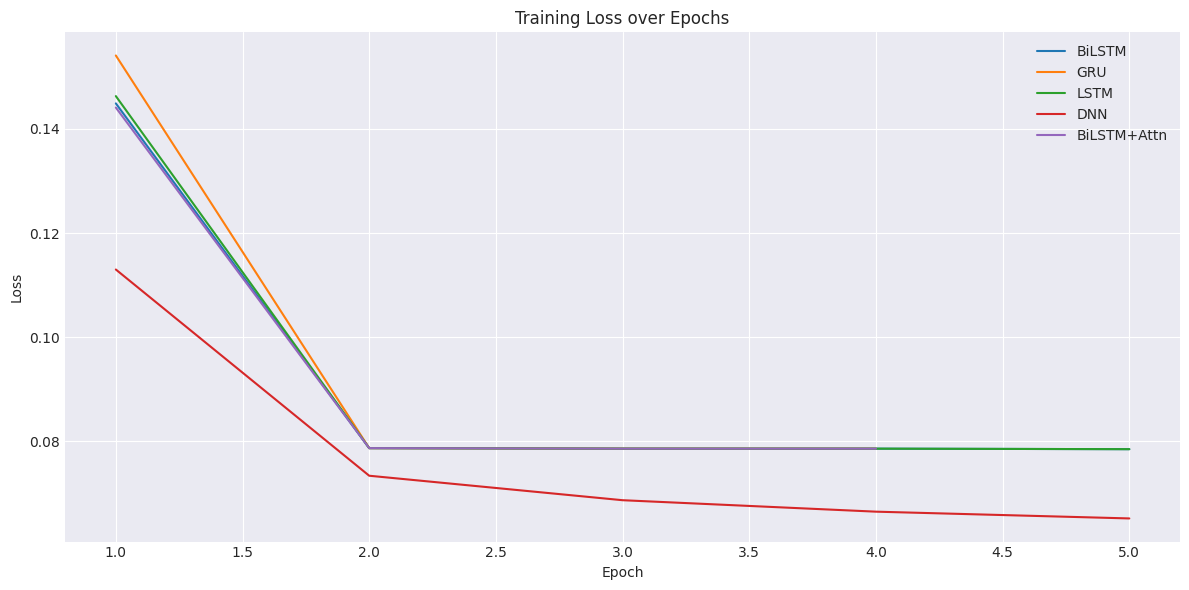

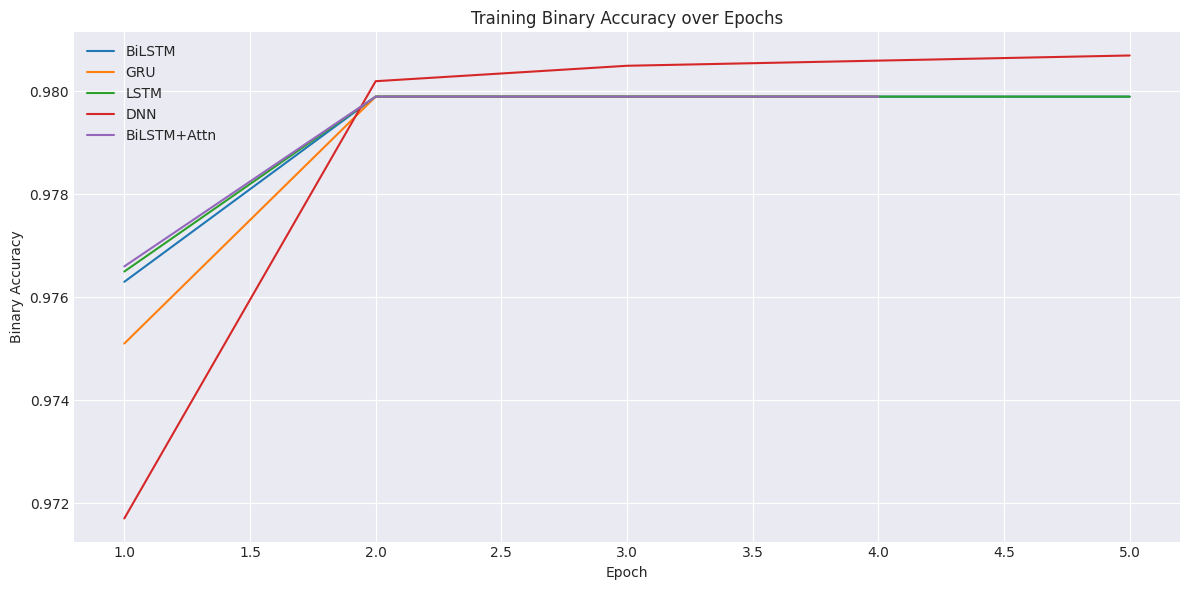

In [64]:
# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(df_train['Epoch'], df_train['BiLSTM_loss'], label='BiLSTM')
plt.plot(df_train['Epoch'], df_train['GRU_loss'], label='GRU')
plt.plot(df_train['Epoch'], df_train['LSTM_loss'], label='LSTM')
plt.plot(df_train['Epoch'], df_train['DNN_loss'], label='DNN')
plt.plot(df_train['Epoch'], df_train['BiLSTM_Attn_loss'], label='BiLSTM+Attn')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training Binary Accuracy
plt.figure(figsize=(12, 6))
plt.plot(df_train['Epoch'], df_train['BiLSTM_binary_acc'], label='BiLSTM')
plt.plot(df_train['Epoch'], df_train['GRU_binary_acc'], label='GRU')
plt.plot(df_train['Epoch'], df_train['LSTM_binary_acc'], label='LSTM')
plt.plot(df_train['Epoch'], df_train['DNN_binary_acc'], label='DNN')
plt.plot(df_train['Epoch'], df_train['BiLSTM_Attn_binary_acc'], label='BiLSTM+Attn')
plt.title('Training Binary Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Visualization of Validation Loss and Binary Accuracy

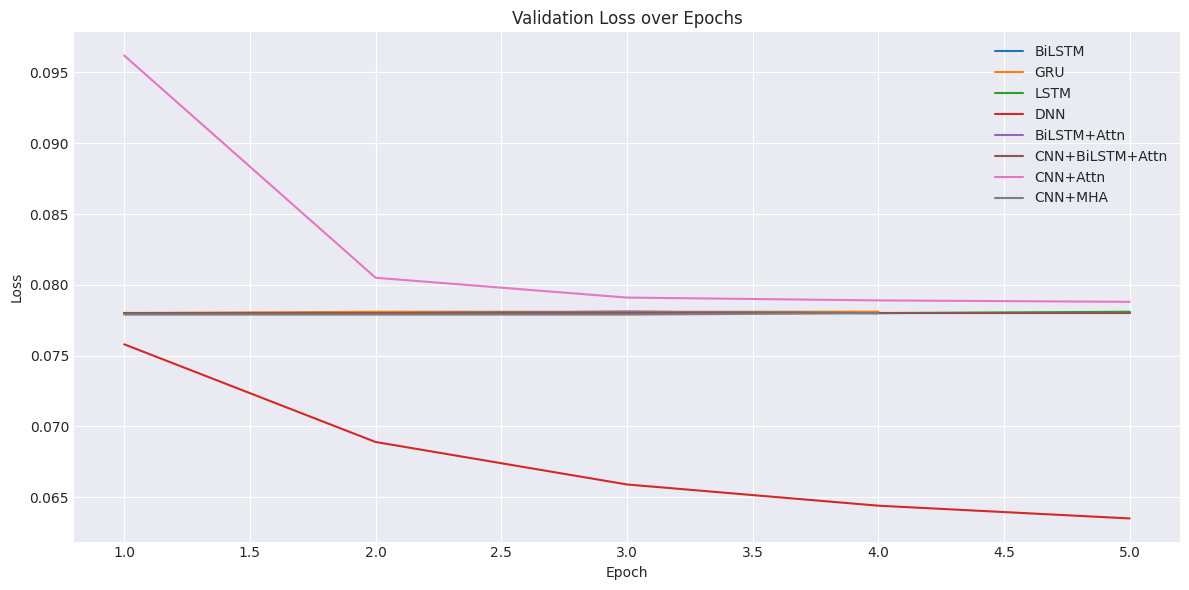

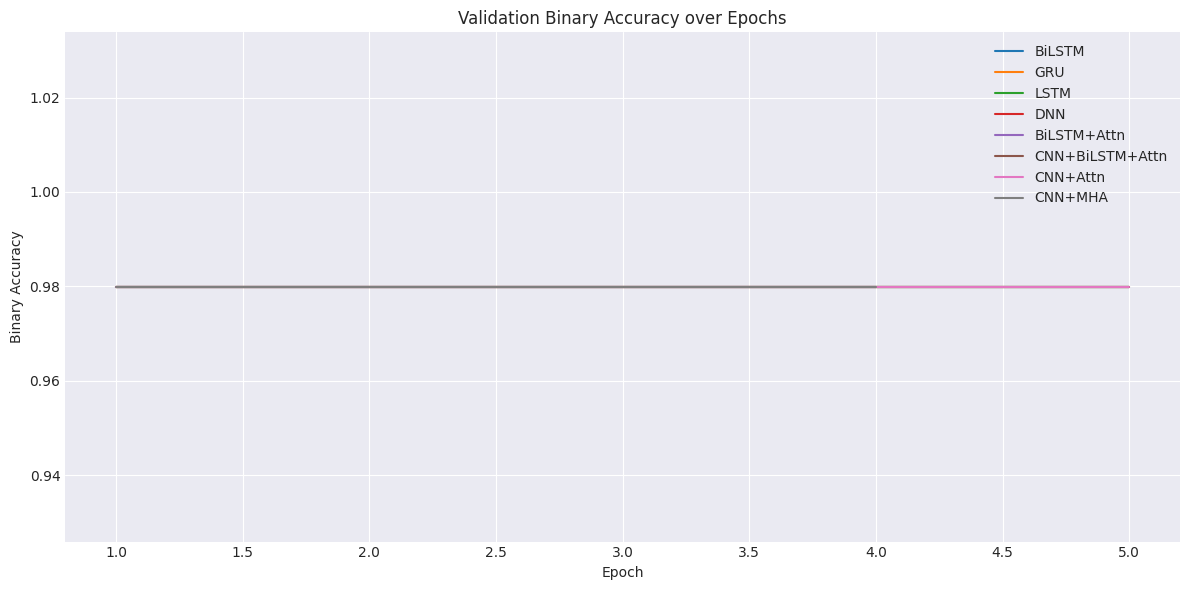

In [71]:
# Plot Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(df_val['Epoch'], df_val['BiLSTM_val_loss'], label='BiLSTM')
plt.plot(df_val['Epoch'], df_val['GRU_val_loss'], label='GRU')
plt.plot(df_val['Epoch'], df_val['LSTM_val_loss'], label='LSTM')
plt.plot(df_val['Epoch'], df_val['DNN_val_loss'], label='DNN')
plt.plot(df_val['Epoch'], df_val['BiLSTM_Attn_val_loss'], label='BiLSTM+Attn')
plt.plot(df_val['Epoch'], df_val['CNN_BiLSTM_Attn_val_loss'], label='CNN+BiLSTM+Attn')
plt.plot(df_val['Epoch'], df_val['CNN_Attn_val_loss'], label='CNN+Attn')
plt.plot(df_val['Epoch'], df_val['CNN_MHA_val_loss'], label='CNN+MHA')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation Binary Accuracy
plt.figure(figsize=(12, 6))
plt.plot(df_val['Epoch'], df_val['BiLSTM_val_bi_acc'], label='BiLSTM')
plt.plot(df_val['Epoch'], df_val['GRU_val_bi_acc'], label='GRU')
plt.plot(df_val['Epoch'], df_val['LSTM_val_bi_acc'], label='LSTM')
plt.plot(df_val['Epoch'], df_val['DNN_val_bi_acc'], label='DNN')
plt.plot(df_val['Epoch'], df_val['BiLSTM_Attn_val_bi_acc'], label='BiLSTM+Attn')
plt.plot(df_val['Epoch'], df_val['CNN_BiLSTM_Attn_val_bi_acc'], label='CNN+BiLSTM+Attn')
plt.plot(df_val['Epoch'], df_val['CNN_Attn_val_bi_acc'], label='CNN+Attn')
plt.plot(df_val['Epoch'], df_val['CNN_MHA_val_bi_acc'], label='CNN+MHA')
plt.title('Validation Binary Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

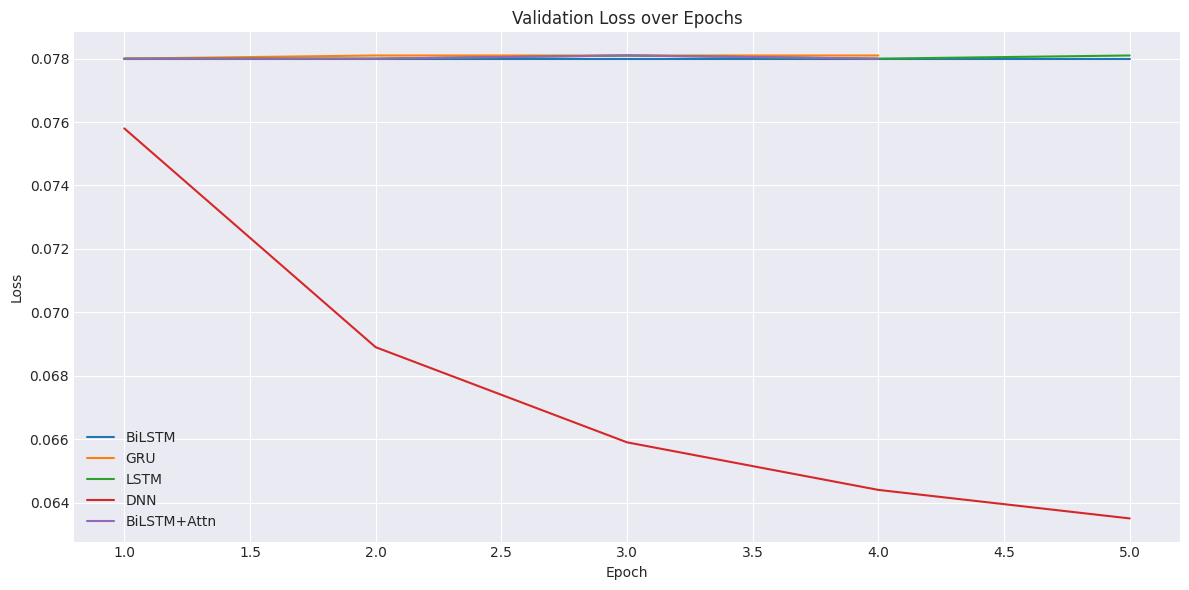

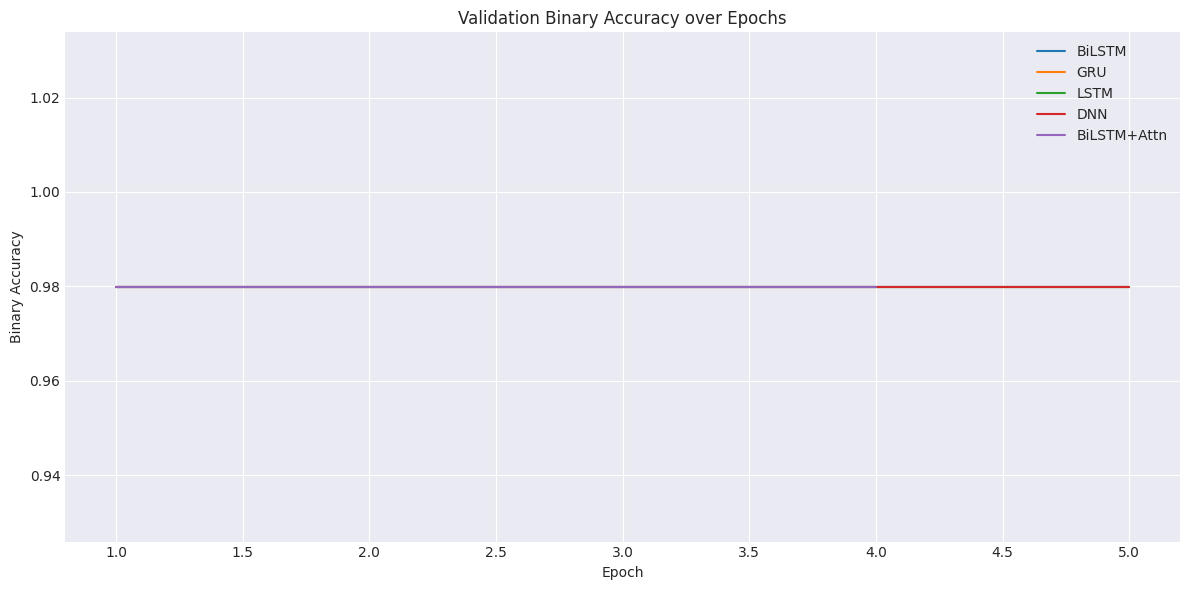

In [72]:
# Plot Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(df_val['Epoch'], df_val['BiLSTM_val_loss'], label='BiLSTM')
plt.plot(df_val['Epoch'], df_val['GRU_val_loss'], label='GRU')
plt.plot(df_val['Epoch'], df_val['LSTM_val_loss'], label='LSTM')
plt.plot(df_val['Epoch'], df_val['DNN_val_loss'], label='DNN')
plt.plot(df_val['Epoch'], df_val['BiLSTM_Attn_val_loss'], label='BiLSTM+Attn')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation Binary Accuracy
plt.figure(figsize=(12, 6))
plt.plot(df_val['Epoch'], df_val['BiLSTM_val_bi_acc'], label='BiLSTM')
plt.plot(df_val['Epoch'], df_val['GRU_val_bi_acc'], label='GRU')
plt.plot(df_val['Epoch'], df_val['LSTM_val_bi_acc'], label='LSTM')
plt.plot(df_val['Epoch'], df_val['DNN_val_bi_acc'], label='DNN')
plt.plot(df_val['Epoch'], df_val['BiLSTM_Attn_val_bi_acc'], label='BiLSTM+Attn')
plt.title('Validation Binary Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**📊 1. Binary Accuracy Bar Plot**

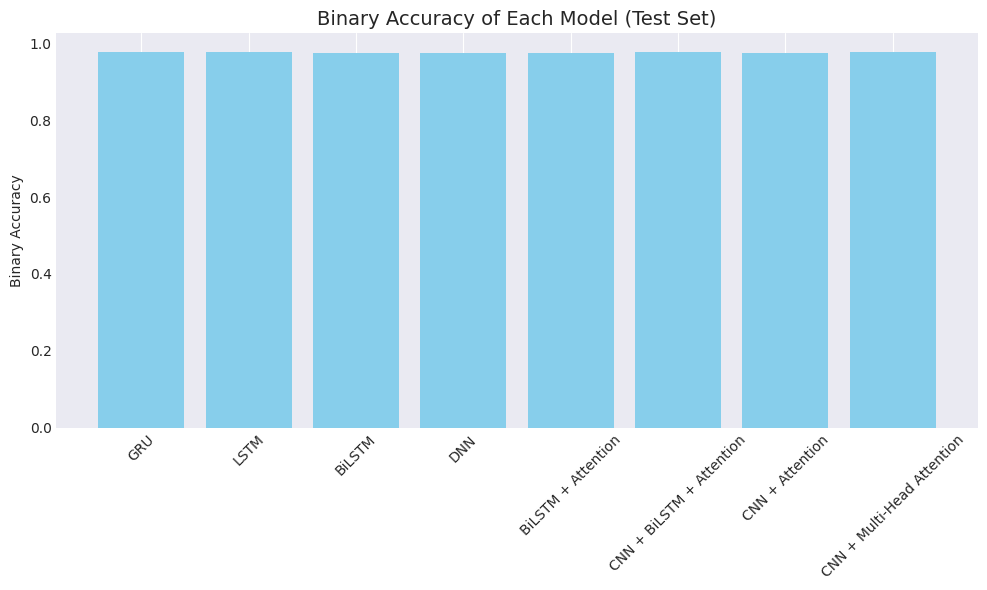

In [73]:
plt.figure(figsize=(10, 6))
plt.bar(df_test['Model'], df_test['Binary Acc'], color='skyblue')
plt.title('Binary Accuracy of Each Model (Test Set)', fontsize=14)
plt.ylabel('Binary Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

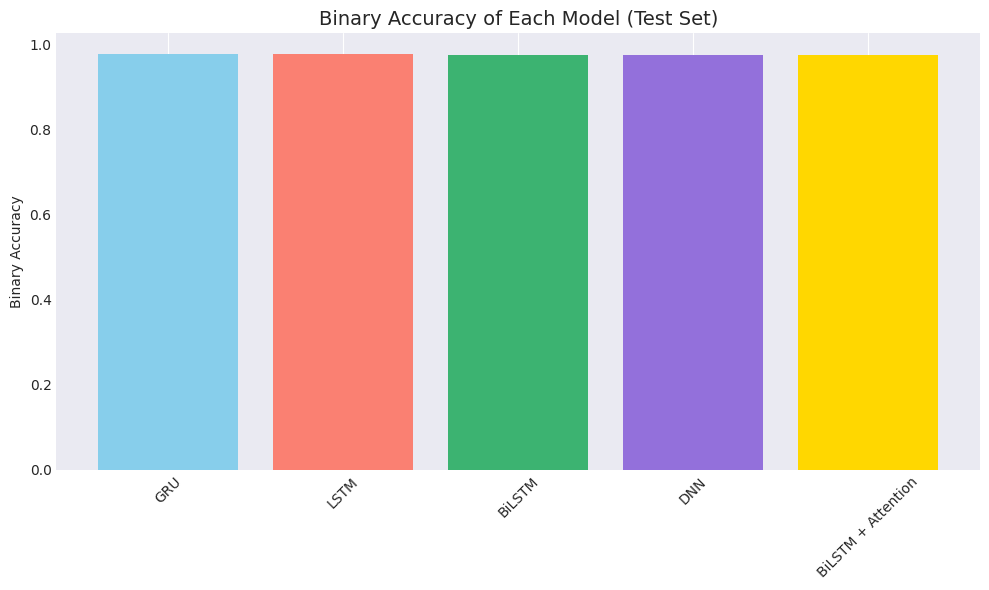

In [84]:
import matplotlib.pyplot as plt

# Select the first 5 models
df_top5 = df_test.iloc[:5]

# Define distinct colors for each bar
colors = ['skyblue', 'salmon', 'mediumseagreen', 'mediumpurple', 'gold']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_top5['Model'], df_top5['Binary Acc'], color=colors)
plt.title('Binary Accuracy of Each Model (Test Set)', fontsize=14)
plt.ylabel('Binary Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

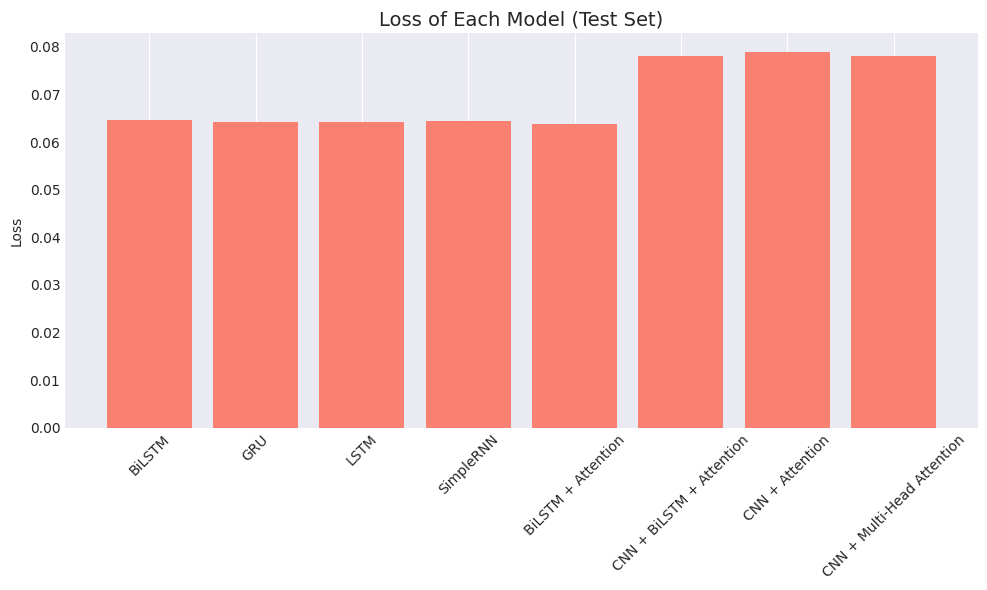

In [50]:
plt.figure(figsize=(10, 6))
plt.bar(df_test['Model'], df_test['Loss'], color='salmon')
plt.title('Loss of Each Model (Test Set)', fontsize=14)
plt.ylabel('Loss')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

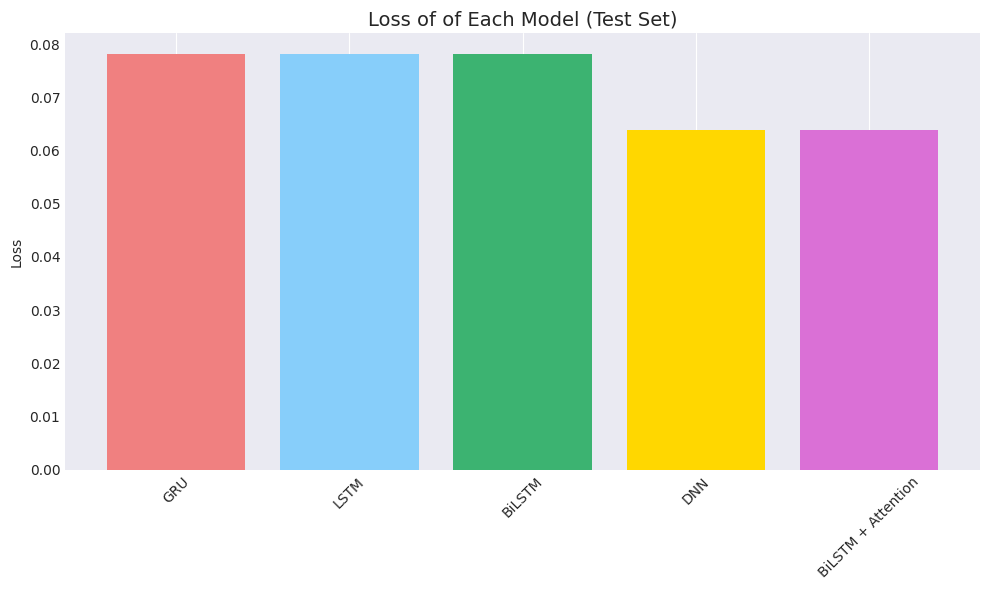

In [83]:
import matplotlib.pyplot as plt

# Select the first 5 models
df_top5 = df_test.iloc[:5]

# Define distinct colors for the bars
colors = ['lightcoral', 'lightskyblue', 'mediumseagreen', 'gold', 'orchid']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_top5['Model'], df_top5['Loss'], color=colors)
plt.title('Loss of of Each Model (Test Set)', fontsize=14)
plt.ylabel('Loss')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

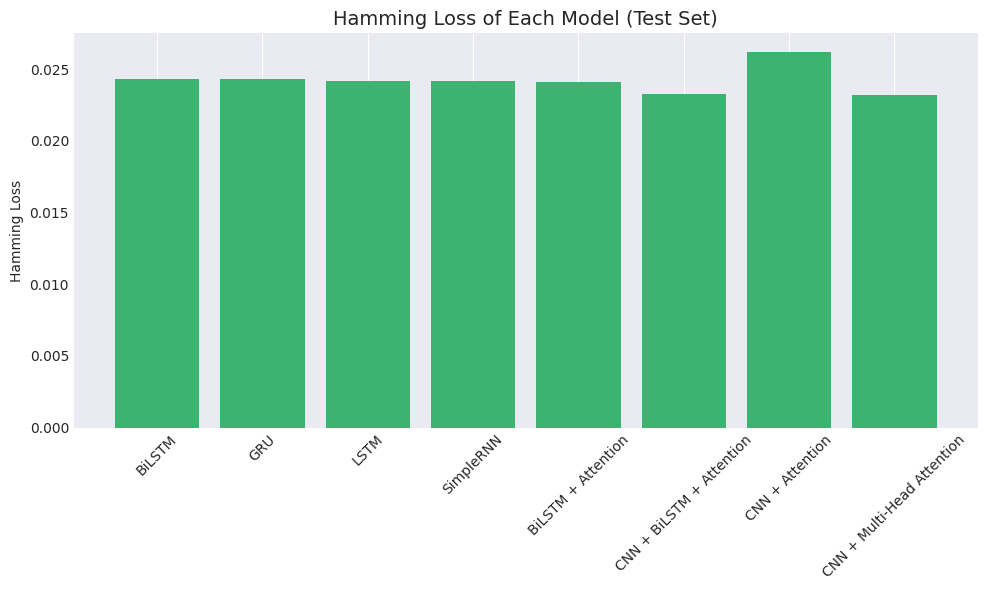

In [52]:
plt.figure(figsize=(10, 6))
plt.bar(df_test['Model'], df_test['Hamming Loss'], color='mediumseagreen')
plt.title('Hamming Loss of Each Model (Test Set)', fontsize=14)
plt.ylabel('Hamming Loss')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

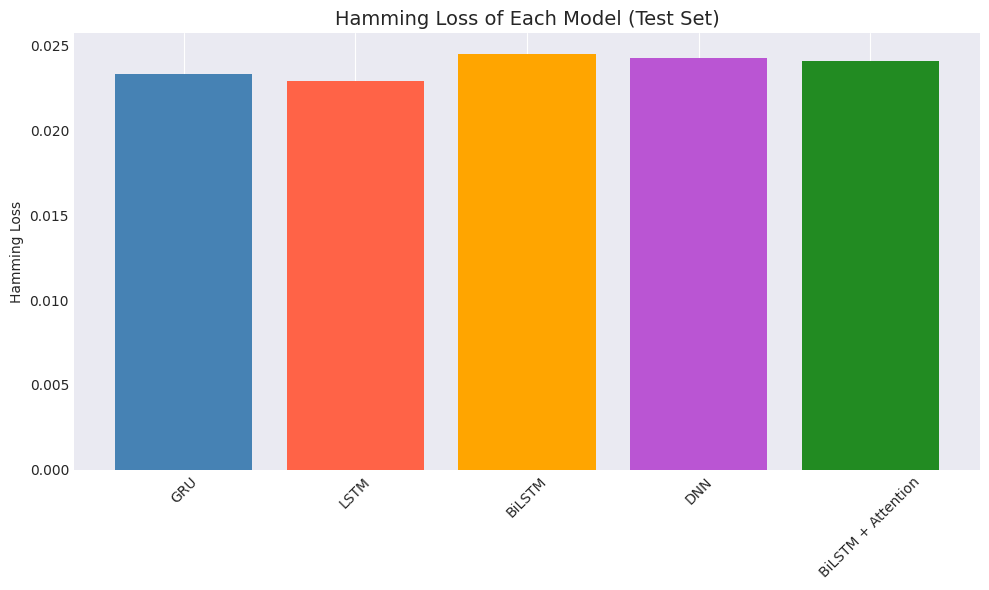

In [82]:
import matplotlib.pyplot as plt

# Select the first 5 models
df_top5 = df_test.iloc[:5]

# Define distinct colors for the bars
colors = ['steelblue', 'tomato', 'orange', 'mediumorchid', 'forestgreen']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_top5['Model'], df_top5['Hamming Loss'], color=colors)
plt.title('Hamming Loss of Each Model (Test Set)', fontsize=14)
plt.ylabel('Hamming Loss')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

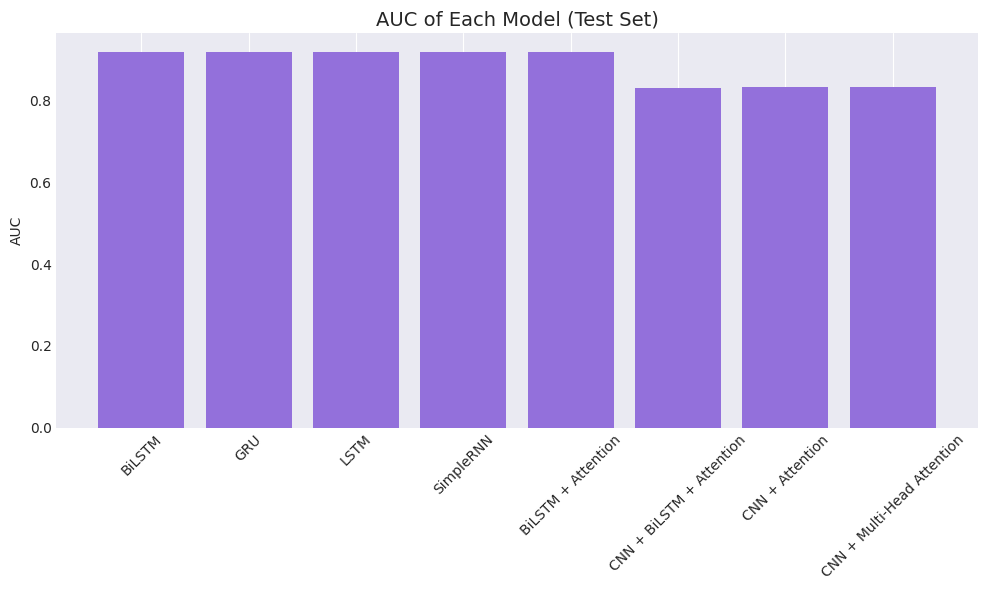

In [53]:
plt.figure(figsize=(10, 6))
plt.bar(df_test['Model'], df_test['AUC'], color='mediumpurple')
plt.title('AUC of Each Model (Test Set)', fontsize=14)
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

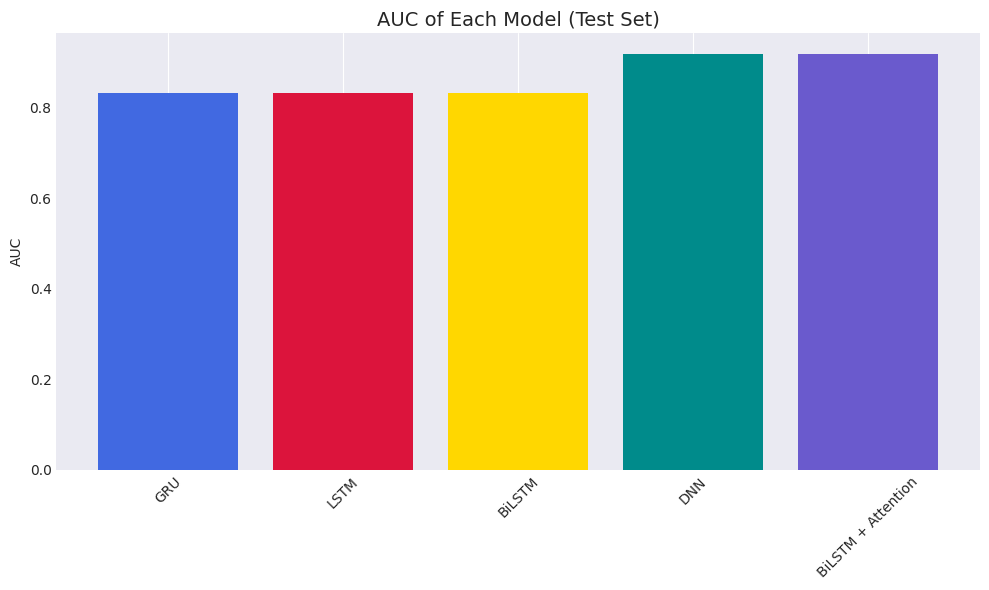

In [81]:
import matplotlib.pyplot as plt

# Select the first 5 models
df_top5 = df_test.iloc[:5]

# Define unique colors for the bars
colors = ['royalblue', 'crimson', 'gold', 'darkcyan', 'slateblue']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_top5['Model'], df_top5['AUC'], color=colors)
plt.title('AUC of Each Model (Test Set)', fontsize=14)
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

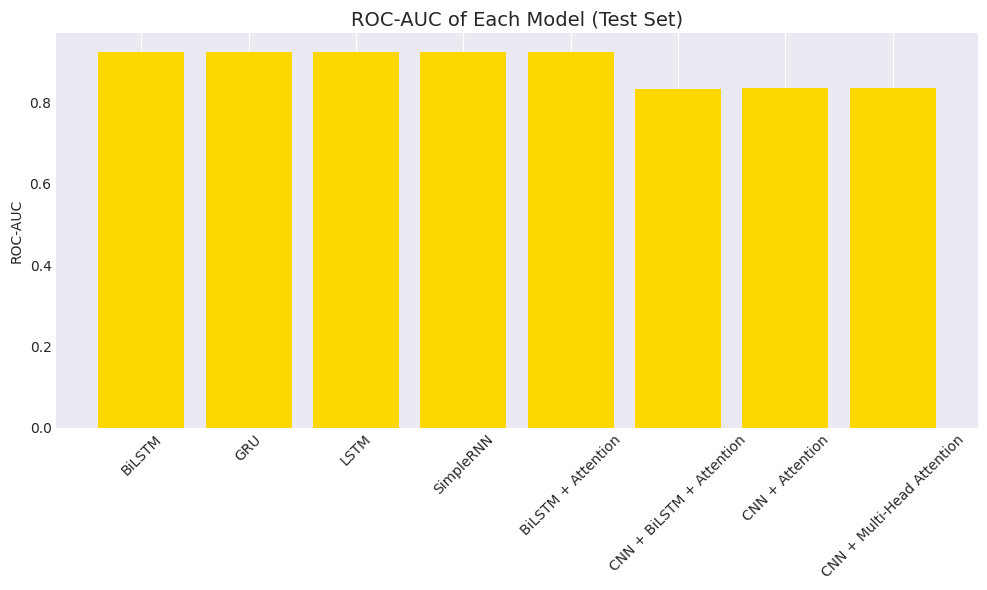

In [55]:
plt.figure(figsize=(10, 6))
plt.bar(df_test['Model'], df_test['ROC-AUC'], color='gold')
plt.title('ROC-AUC of Each Model (Test Set)', fontsize=14)
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

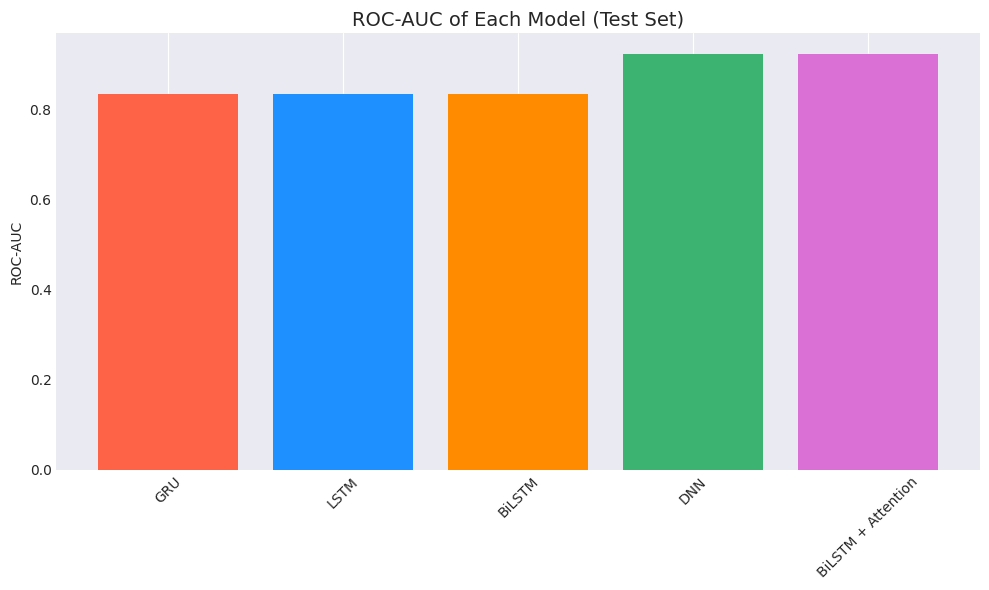

In [80]:
import matplotlib.pyplot as plt

# Select the first 5 models
df_top5 = df_test.iloc[:5]

# Define unique colors for each bar
colors = ['tomato', 'dodgerblue', 'darkorange', 'mediumseagreen', 'orchid']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_top5['Model'], df_top5['ROC-AUC'], color=colors)
plt.title('ROC-AUC of Each Model (Test Set)', fontsize=14)
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

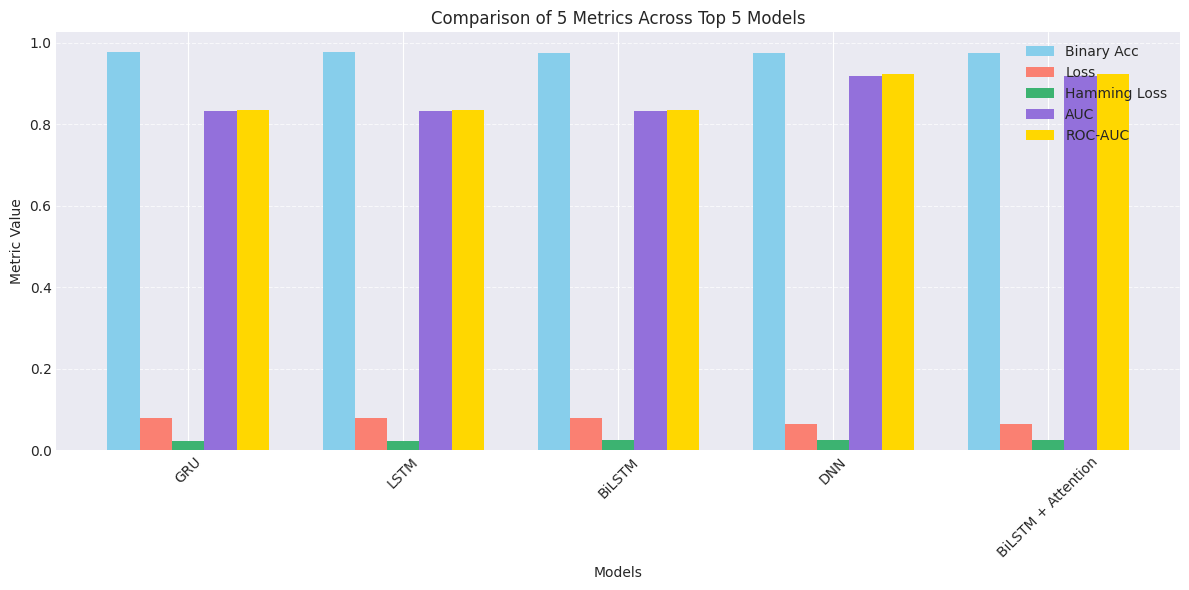

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Select top 5 models
df_top5 = df_test.iloc[:5]

# Metrics to plot
metrics = ['Binary Acc', 'Loss', 'Hamming Loss', 'AUC', 'ROC-AUC']
colors = ['skyblue', 'salmon', 'mediumseagreen', 'mediumpurple', 'gold']

# Setup bar positions
x = np.arange(len(df_top5['Model']))  # the label locations
bar_width = 0.15
offsets = [-2, -1, 0, 1, 2]  # for 5 metrics

# Plot
plt.figure(figsize=(12, 6))

for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.bar(x + offsets[i]*bar_width, df_top5[metric], width=bar_width, label=metric, color=color)

# Formatting
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Comparison of 5 Metrics Across Top 5 Models')
plt.xticks(ticks=x, labels=df_top5['Model'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()